### Things to be done here

- Maximum PMT Ratio and Event position (Assume its higher just under PMTs)
- Maximum PMT Ratio and Chi squared increase distance (Assume its wider when PMT ratio is low or equivalently whne one is far away from the PMT centers)

TODO add the things with dead pmts here as well

## Load Things

In [1]:
# Utilix broken in this version tag -> Cancel cell after 2s then start again
import os
os.environ["XENON_CONFIG"] = '/Code/xenon.config'
import straxen

2025-01-11 14:52:01,914 - admix - WARNING - Initializing utilix DB failed. You cannot do database operations


DB initialization failed


In [2]:
# imports
import sys, os 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tensorflow
import scipy
import keras
import time
from IPython.display import clear_output
from functools import partial
import h5py
#import gc
#from numba import cuda 

import subprocess


# import functions
sys.path.append(os.path.join(os.getcwd(), 'ActualThesisWork'))
%load_ext autoreload
%autoreload 2
from functions import *


tensorflow.config.optimizer.set_jit(False)
# The below is neat when on but it prints over 1000 msg/s 
tensorflow.debugging.set_log_device_placement(False) 
#tensorflow.config.set_visible_devices([], 'GPU') # Because It keeps running out of memory and doesnt remove the data

pmt_pos = straxen.pmt_positions()
pmt_radius = straxen.tpc_pmt_radius
pmt_pos_top = pmt_pos[pmt_pos.array == "top"].to_numpy()
n_pmts = pmt_pos_top.shape[0]

2025-01-11 14:52:03.457669: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 14:52:03.509859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-11 14:52:03.675202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 14:52:03.675245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 14:52:03.690281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
all_data_df = pd.read_pickle('/Code/processed_data/all_data_min_filter.pkl.gz', compression='gzip')
patterns = all_data_df.loc[:,'s2_area_per_channel']
patterns = np.vstack(patterns.to_numpy())
ei = all_data_df.loc[:, all_data_df.columns != 's2_area_per_channel']

In [4]:
dead_pmts =     np.argwhere(tensorflow.math.reduce_mean(patterns,axis=0) == 0).reshape(-1)
not_dead_pmts = np.argwhere(tensorflow.math.reduce_mean(patterns,axis=0) != 0).reshape(-1)

In [5]:
# Load Neural Nets
# Load rLCE
from tensorflow import keras
import tensorflow as tf
class FilterAlive(keras.layers.Layer):
    def __init__(self, alive_pmt_indices, **kwargs):
        super().__init__(**kwargs)
        self.alive = alive_pmt_indices
    
    def call(self, X):
        return tf.gather(X, self.alive, axis = -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.alive.shape)
    
# Taken from Shenyang and slightly modified
import math
class Likelihood(tf.keras.layers.Layer):
    def __init__(self, n_pmts, **kwargs):
        super().__init__(**kwargs)
        self.n_pmts = n_pmts

    def build(self, input_shape):
        self.sigma = self.add_weight(
            shape=(self.n_pmts, ), dtype=tf.float32, name='sigma',
            initializer=tf.keras.initializers.Ones(),
            trainable=True)
        self.power = self.add_weight(
            shape=(self.n_pmts, ), dtype=tf.float32, name='power',
            initializer=tf.keras.initializers.Ones(),
            trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        
        cex, cob = inputs[0], inputs[1]
        c = tf.reduce_sum(cob, axis=-1)
        c = tf.reshape(c, (-1, 1))
        cex = cex * c # aex/aob is [events*pmtsize tensor]
        broaden = 1.2
        cons= 0.1
        y = - (
            ((cob * tf.math.log(cex) -tf.math.lgamma(cob + 1)) - 
                (cex * tf.math.log(cex) - tf.math.lgamma(cex + 1)) 
            )
        * cex / (broaden * cex + (0.1* self.sigma * cex**self.power) ** 2 + cons)
        - 0.5 * tf.math.log(2 * math.pi * ( broaden * cex + (0.1 * self.sigma * cex**self.power) **2 + cons)))
        
        chi2 = - 2 * (
            ((cob * tf.math.log(cex) -tf.math.lgamma(cob + 1)) - 
                (cex * tf.math.log(cex) - tf.math.lgamma(cex + 1)) 
            )
        * cex / (broaden * cex + (0.1* self.sigma * cex**self.power) ** 2 + cons)
        )
        return tf.reduce_sum(y, axis=1) / self.n_pmts, tf.reduce_sum(chi2, axis=1) / self.n_pmts#, 2*keras.backend.sum(cob*tensorflow.math.log(cob/cex) - (cob - cex), axis=1) / self.n_pmts

def _logl_loss(patterns, likelihood):
    return likelihood[0]
import sys
sys.path.append(os.path.join(os.getcwd(), 'ActualThesisWork'))
%load_ext autoreload
%autoreload 2
from functions import *

with tf.keras.utils.custom_object_scope({'_logl_loss': _logl_loss}):
    model = tf.keras.models.load_model("/Code/LCE_SR1/LCE_Neural_SR1")
model_chi2 = tf.keras.Model(
            model.inputs, model.get_layer("Likelihood").output
        )
loss_weights = model_chi2.get_layer('Likelihood').get_weights()

model_pattern = tf.keras.Model(model.inputs[0],
                                model.get_layer('normalization_1').output)


pmt_positions = pmt_pos_top[:,-2:]
i0s = np.array([4.3321685e-03, 4.8899297e-03, 4.8685744e-03, 5.0057671e-03, 5.0926125e-03, 3.8192207e-03, 5.0742184e-03, 4.5723971e-03, 4.4081882e-03, 4.2195930e-03, 3.8486260e-03, 4.1838391e-03, 4.0647872e-03, 4.7091218e-03, 5.0830012e-03, 3.3815645e-03, 4.4174474e-03, 4.2217500e-03, 3.8883914e-03, 4.1160719e-03, 4.2805159e-03, 3.8807073e-03, 4.0655909e-03, 4.1060778e-03, 4.1315975e-03, 4.7936141e-03, 3.2942444e-03, 4.9037142e-03, 7.7721901e-10, 3.8406078e-03, 4.3384172e-03, 4.0945616e-03, 4.1323849e-03, 3.5376074e-03, 4.1092960e-03, 4.0294765e-03, 4.2530410e-03, 4.3881517e-03, 4.3557761e-03, 5.2265157e-03, 4.7099791e-03, 4.0602549e-03, 3.7400448e-03, 3.7515005e-03, 4.2108428e-03, 3.9731641e-03, 3.8805525e-03, 4.0709740e-03, 4.3926593e-03, 3.8181171e-03, 4.2493315e-03, 4.1600037e-03, 4.4732001e-03, 5.6759203e-03, 5.1910682e-03, 4.2152693e-03, 3.8856652e-03, 3.9358442e-03, 3.9593815e-03, 4.5243143e-03, 3.3824742e-03, 4.2228648e-03, 4.1722674e-03, 4.0427274e-03, 4.0417486e-03, 3.9301920e-03, 3.6303743e-03, 4.8567164e-03, 4.6816585e-03, 4.6605649e-03, 4.1111340e-03, 3.9693397e-03, 3.9644395e-03, 3.6394752e-03, 4.1905139e-03, 3.8725468e-03, 4.0893927e-03, 4.0443619e-03, 3.8839907e-03, 4.1380730e-03, 3.7537001e-03, 3.9355555e-03, 3.7318014e-03, 3.8118435e-03, 5.2085049e-03, 4.2290958e-03, 4.0234900e-03, 3.5676390e-03, 3.9484301e-03, 4.2167031e-03, 4.2368169e-03, 4.1302987e-03, 4.2008958e-03, 4.2801257e-03, 4.1032447e-03, 4.4811480e-03, 4.2696339e-03, 3.6081157e-03, 4.0258458e-03, 3.9694263e-03, 4.5943419e-03, 4.1785482e-03, 4.4084764e-03, 3.7471219e-03, 4.4116797e-03, 4.0504644e-03, 4.1418886e-03, 4.0030433e-03, 1.0424008e-09, 4.2052269e-03, 4.2578629e-03, 4.5622797e-03, 4.0193330e-03, 4.1911956e-03, 4.2375987e-03, 4.2547933e-03, 3.5730435e-03, 4.5289211e-03, 4.9987421e-03, 4.0041506e-03, 3.9206431e-03, 8.3443069e-10, 4.0859459e-03, 4.0822630e-03, 4.1334494e-03, 4.3958416e-03, 4.0311846e-03, 4.0570530e-03, 4.8540146e-03, 4.1181887e-03, 4.2905537e-03, 3.9505828e-03, 4.1115014e-03, 4.2378809e-03, 5.4844008e-03, 5.1576579e-03, 4.2841639e-03, 4.0341225e-03, 3.7783773e-03, 4.0266900e-03, 4.2498759e-03, 4.2951452e-03, 4.3143658e-03, 4.1313837e-03, 2.1348676e-09, 4.1051428e-03, 4.2898878e-03, 4.2597717e-03, 3.8951659e-03, 4.0271045e-03, 4.2793071e-03, 4.0357350e-03, 3.9217505e-03, 3.9514182e-03, 4.1377540e-03, 3.9742026e-03, 1.2402929e-09, 3.9072270e-03, 4.0098960e-03, 4.4543701e-03, 4.4421032e-03, 4.2735850e-03, 4.3578045e-03, 3.8933735e-03, 6.5661332e-10, 4.0731006e-03, 4.1153133e-03, 3.7559553e-03, 5.4024002e-03, 4.3515279e-03, 3.6778662e-03, 4.5253038e-03, 4.1828337e-03, 4.0867706e-03, 4.4803121e-03, 4.2735278e-03, 4.0277829e-03, 3.0061767e-10, 4.3173237e-03, 3.6315513e-03, 3.7630824e-03, 3.9289133e-03, 3.7644394e-03, 4.8030056e-03, 4.8184181e-03, 3.8601037e-03, 4.0834383e-03, 3.8238778e-03, 3.9222855e-03, 4.1271560e-03, 4.2299703e-03, 4.2282301e-03, 4.2152260e-03, 4.2188424e-03, 4.2601079e-03, 4.1266191e-03, 3.9463951e-03, 4.1020829e-03, 5.2572191e-03, 5.6053256e-03, 4.0953509e-03, 4.2140838e-03, 4.0869401e-03, 4.3971362e-03, 3.9943284e-03, 3.9221593e-03, 4.0147733e-03, 3.9175176e-03, 4.2255772e-03, 3.2839905e-03, 3.5796922e-03, 4.3001343e-03, 5.2305199e-03, 5.2561881e-03, 4.1396990e-03, 3.9065215e-03, 4.0462790e-03, 4.4015646e-03, 3.9156144e-03, 4.1807001e-03, 3.7336536e-03, 2.8916472e-03, 4.3796739e-03, 3.7167547e-03, 3.8832054e-03, 4.9040765e-03, 4.0531182e-03, 4.4816649e-03, 4.2975284e-03, 4.2031519e-03, 3.7932515e-03, 3.6113819e-03, 4.0321909e-03, 4.0693702e-03, 3.8203422e-03, 4.2403601e-03, 4.1839005e-03, 4.4256304e-03, 4.6902383e-03, 4.6948199e-03, 4.1613793e-03, 4.3950700e-03, 4.9116057e-03, 4.2219968e-03, 4.4758134e-03, 4.3810243e-03, 5.3808806e-03, 4.1074217e-03, 4.7744270e-03, 5.3171408e-03, 5.0322791e-03, 4.8009814e-03, 4.0162178e-03])[not_dead_pmts]
rLCE_params = [1.6266745e+00,  9.4918861e+00, -4.2176653e-05,  7.7804564e-03,]

n_alive_pmts = n_pmts - len(dead_pmts)
# Model modified for Radial LCE
input_x = tf.keras.layers.Input(shape=(2,), name='xx', dtype=tf.float32)
x = tf.keras.layers.RepeatVector(n_alive_pmts, name='repeat_vector')(input_x)
rho = GetRadius((n_alive_pmts, 1), keras.backend.variable(pmt_positions[not_dead_pmts]), name='Event_Distance')(x)
#WallDist = GetWallDist((n_alive_pmts, 1),tpc_radius,name="WallDist")(x)
x = RadialLCELayer(guess=rLCE_params, n_groups=1, group_slices=np.arange(n_alive_pmts).reshape(1,-1),name='radial_LCE')((rho))
x = I0Layer(n_alive_pmts, name='i0')(x)
x = NormalizationLayer(name='normalization')(x)
# We pass the full array
input_y = tf.keras.layers.Input(shape=(n_pmts,), name='yy', dtype=tf.float32)
y_mod = FilterAlive(not_dead_pmts, name='aliveFilter')(input_y)
y, chi2 = Likelihood(n_alive_pmts, name='Likelihood')([x, y_mod])
radial_mc = tf.keras.models.Model(inputs=[input_x, input_y],
                                    outputs=[y, chi2], name='Radial_mc')

radial_mc.get_layer('i0').set_weights([i0s]) 
radial_mc.get_layer('i0').trainable = False
# No trainable Params but recongized as for some reason
radial_mc.get_layer('Event_Distance').trainable = False
#radial_mc.get_layer('WallDist').trainable = False
radial_mc.get_layer('radial_LCE').trainable = True
radial_mc.get_layer('Likelihood').trainable = False
radial_mc.get_layer('Likelihood').set_weights(loss_weights)
# Def pattern model
radial_patterns = tf.keras.Model(radial_mc.inputs[0],
                    radial_mc.get_layer('normalization').output ) 

# Loss Model
input_x = tf.keras.layers.Input(shape=(n_alive_pmts,), name='xx', dtype=tf.float32)
input_y = tf.keras.layers.Input(shape=(n_alive_pmts,), name='yy', dtype=tf.float32)
y, chi2 = Likelihood(n_alive_pmts, name='Likelihood')([input_x, input_y])
loss_model = tf.keras.Model(inputs=[input_x, input_y],
                                    outputs=[y, chi2], name='Loss_Model') 

allow_njit = True
keras_loss = logl_loss_generator(pmt_pos_top[not_dead_pmts,-2:], keras.backend, not_dead_pmts = None, cap=float('inf'), allow_njit=allow_njit)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Base Behavior

Supporting Plots for Base Problem

In [278]:
pos = np.array(all_data_df.position.to_list())

angle = np.radians(30)  # Convert angle to radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
pos_rot = np.dot(rotation_matrix, np.vstack((pos[:,0], pos[:,1])))

act_qes = [32.2,30.8,28.6,29.7,29.8,32.2,32.1,31.1,31.1,31.1,31.1,31.1,31.1,31.2,32.2,29.6,30.7,33.9,30.2,29.7,32.2,33.2,32.2,30.0,31.2,30.9,28.8,28.5,32.1,31.0,32.6,32.6,32.6,29.8,32.7,32.8,32.8,31.2,33.6,31.3,29.5,32.1,31.2,32.6,33.1,33.1,30.0,33.2,33.2,28.6,32.5,32.2,34.5,32.2,33.2,30.2,32.1,29.6,33.5,33.6,32.8,33.2,33.6,33.6,33.2,30.6,30.5,31.3,30.0,29.4,32.1,30.9,33.2,33.1,33.6,33.8,34.0,33.8,30.4,33.6,32.5,33.2,29.2,30.9,30.0,32.4,30.8,30.6,31.9,33.1,34.6,33.8,34.0,33.9,34.0,35.2,33.6,29.6,32.3,32.3,32.1,33.0,32.1,29.5,33.1,33.7,33.5,33.8,33.9,34.0,34.1,33.9,30.5,33.7,32.8,33.2,29.0,31.4,32.8,29.7,33.0,32.5,33.1,33.9,33.5,34.0,34.1,34.1,34.0,33.9,33.6,31.4,32.2,32.3,32.8,32.5,30.6,32.0,33.5,32.5,33.7,34.0,33.9,33.8,34.0,33.6,33.0,32.9,32.3,32.3,30.0,29.4,28.4,32.0,33.0,33.0,33.6,33.7,33.4,33.9,33.4,33.6,33.3,32.9,31.4,31.4,30.1,30.6,32.0,32.1,29.3,32.5,33.0,33.4,33.7,33.7,33.7,33.2,33.3,32.9,32.8,32.6,30.1,28.5,29.2,32.8,32.0,29.5,33.0,33.4,33.9,33.4,33.4,33.9,32.9,32.3,30.1,30.1,31.5,32.2,29.3,31.5,32.5,33.0,33.0,32.1,31.5,31.3,32.9,28.6,29.2,31.5,28.6,33.0,30.5,29.4,32.5,32.5,30.4,32.4,32.4,29.9,32.4,31.5,30.2,32.3,31.9,30.5,31.9,31.9,28.6,31.6,31.6,29.1,31.6,30.8,30.2,32.3,30.5,30.5,29.1,31.7,33.8,32.4,29.7,28.6,32.3,30.4,29.0,31.3,29.9,28.6,30.3]
act_qes = np.array(act_qes)
act_qes /= act_qes.max()
act_qes=act_qes.reshape(1,-1)

# Patterns
patterns = np.array(all_data_df['s2_area_per_channel'].to_list()) / act_qes
patterns /= patterns.sum(axis=-1)[:,np.newaxis]

response_orders = np.sort(patterns, axis=-1)[:,::-1] 

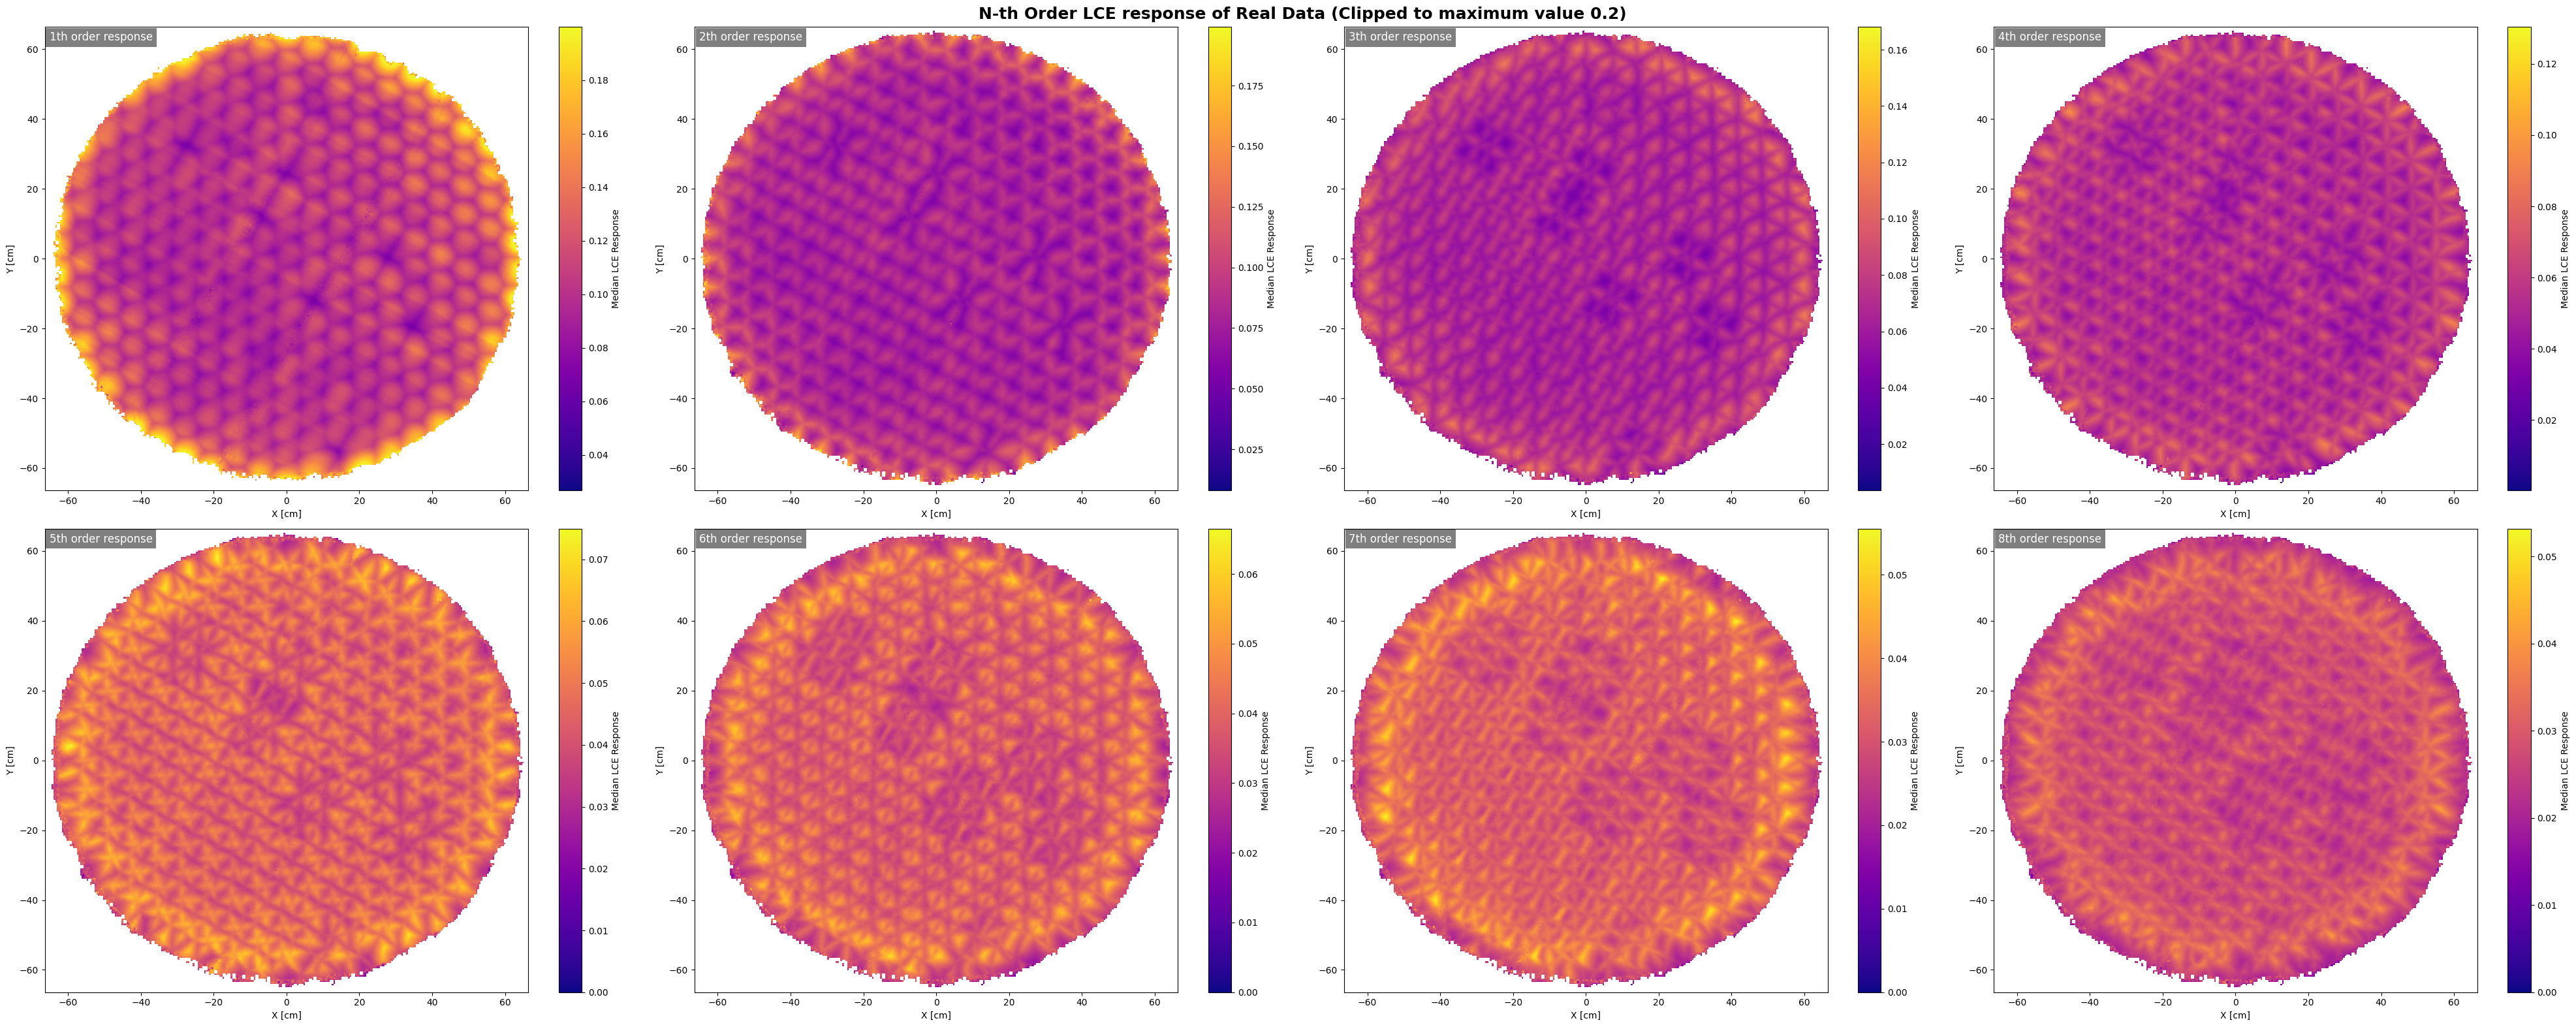

In [279]:
# Make order Plots
from scipy.stats import binned_statistic_2d

fig, ax = plt.subplots(2,4, figsize=(40,16))
ax = ax.flatten()

for i in range(8):
    # Some points mess with color scale for first order
    tmp_bmap = response_orders[:,i] < 0.2
    stat, x_edges, y_edges, _ = binned_statistic_2d(
        pos[tmp_bmap,0], pos[tmp_bmap,1], response_orders[tmp_bmap,i], statistic='median', bins=300
    )

    im = ax[i].imshow(
        stat.T,              # Transpose to align correctly with axes
        origin='lower',      # Align the origin to the bottom-left
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],  # Set axis limits
        aspect='auto',       # Adjust aspect ratio
        cmap='plasma'       # Choose a colormap
    )
    plt.colorbar(im, ax= ax[i], label='Median LCE Response')
    ax[i].set_xlabel('X [cm]')
    ax[i].set_ylabel('Y [cm]')

    ax[i].text(
        0.01, 0.99,                   # Position (x, y) in axes coordinates (0 to 1)
        f'{i+1}th order response',                # Text to display
        transform=ax[i].transAxes,       # Use axes coordinates
        fontsize=12,                  # Font size
        va='top', ha='left',          # Alignment
        color='white',                # Text color (optional, depending on background)
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')  # Background box
    )
    ax[i].set_xlim(-66.4,66.4)
    ax[i].set_ylim(-66.4,66.4)
plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('N-th Order LCE response of Real Data (Clipped to maximum value 0.2)', fontsize=18, fontweight="bold")
plt.show()


In [19]:
pmt_pos_rot = np.dot(rotation_matrix, np.vstack((pmt_pos_top[:,-2], pmt_pos_top[:,-1])))
unique_pmt_y = np.unique((pmt_pos_rot[1]*1000).astype('int')/1000)

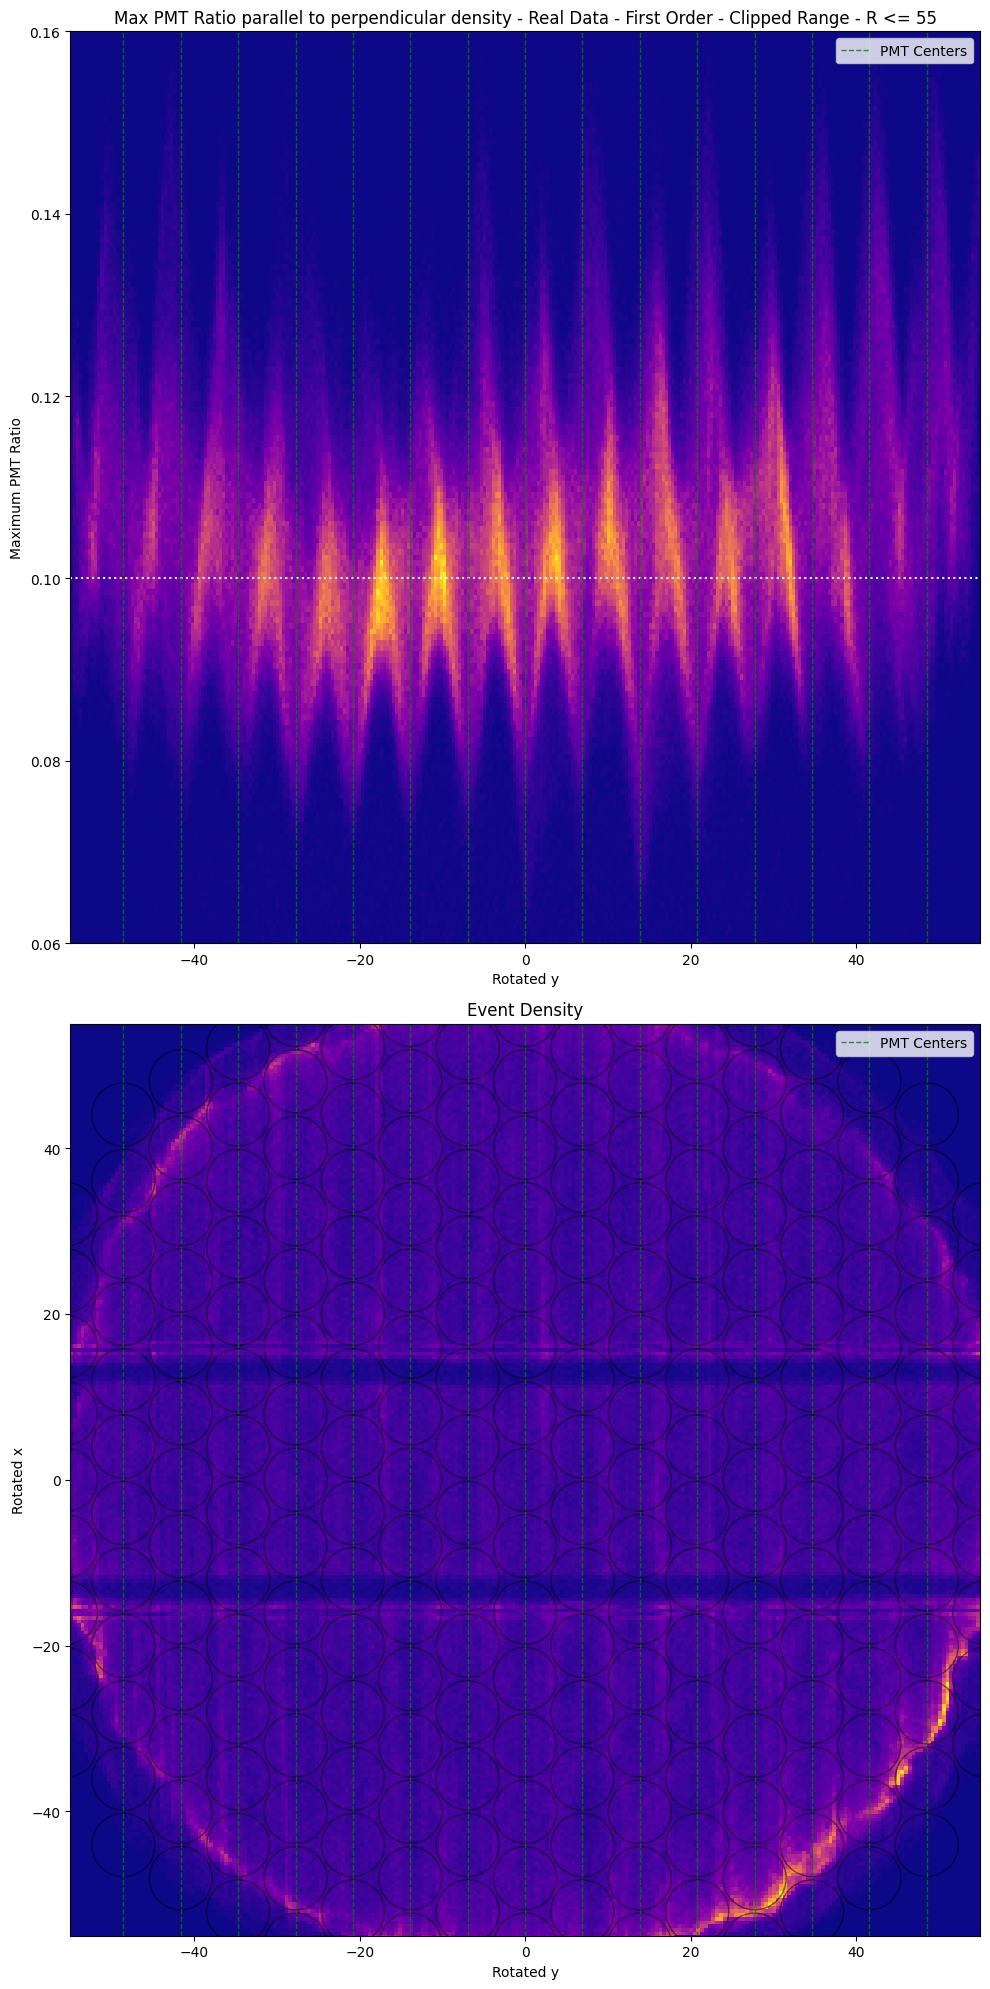

In [281]:
# Plot Mxa PMT as rotated y cross section
"""
Not very usefull but we would expect the outer three PMT peaks to Have a similar response
"""


fig, axes = plt.subplots(2,1, figsize=(10, 20))
ax =axes[0]
i=0
tmp_bmap = response_orders[:,i] < 0.2
tmp_bmap &= np.linalg.norm(pos, axis=-1) < 55
ax.hist2d(pos_rot[1][tmp_bmap], response_orders[tmp_bmap,i], bins = 300, cmap = 'plasma')
ax.set_title("Max PMT Ratio parallel to perpendicular density - Real Data - First Order - Clipped Range - R <= 55")
ax.set_xlabel("Rotated y")
ax.set_ylabel("Maximum PMT Ratio")
ax.set_ylim(0.06,0.16)
ax.axvline(unique_pmt_y[0], c='g',linestyle='--', linewidth=1,alpha=0.8,label='PMT Centers')
ax.axhline(0.10, c='w', linestyle='dotted')
for i in unique_pmt_y[1:]:
    ax.axvline(i, c='g',linestyle='--', linewidth=1,alpha=0.8)
ax.legend()

ax =axes[1]
ax.hist2d(pos_rot[1], pos_rot[0], bins = 300, cmap = 'plasma')
ax.set_title("Event Density")
ax.set_xlabel("Rotated y")
ax.set_ylabel("Rotated x")
ax.axvline(unique_pmt_y[0], c='g',linestyle='--', linewidth=1,alpha=0.8,label='PMT Centers')
for i in unique_pmt_y[1:]:
    ax.axvline(i, c='g',linestyle='--', linewidth=1,alpha=0.8)
pmt_pos_tmp = pmt_pos_top.copy()
pmt_pos_tmp[:,-1] = pmt_pos_rot[0]
pmt_pos_tmp[:,-2] = pmt_pos_rot[1]
plot_pmt_circles(ax=ax, pmt_pos=pmt_pos_tmp,alpha=0.5)
ax.set_xlim(axes[0].get_xlim())
ax.set_ylim(axes[0].get_xlim())
ax.legend()

plt.tight_layout()

## PMT Geometry and LCE

In [172]:
# Generate Models

rLCE_params = [1.6266745e+00,  9.4918861e+00, -4.2176653e-05,  7.7804564e-03,]
n_alive_pmts = n_pmts - len(dead_pmts)

# Model modified for Radial LCE
input_x = tf.keras.layers.Input(shape=(2,), name='xx', dtype=tf.float32)
x = tf.keras.layers.RepeatVector(n_alive_pmts, name='repeat_vector')(input_x)

pmt_pos_rot = np.dot(rotation_matrix, np.vstack((pmt_pos_top[:,-2], pmt_pos_top[:,-1])))
pmt_pos_tmp = pmt_pos_top.copy()
pmt_pos_tmp[:,-1] = pmt_pos_rot[0]
pmt_pos_tmp[:,-2] = pmt_pos_rot[1]
pmt_pos_rot = pmt_pos_tmp[:,-2:]


rho = GetRadius((n_alive_pmts, 1), keras.backend.variable(pmt_pos_rot[not_dead_pmts]), name='Event_Distance')(x)
#WallDist = GetWallDist((n_alive_pmts, 1),tpc_radius,name="WallDist")(x)
x = RadialLCELayer(guess=rLCE_params, n_groups=1, group_slices=np.arange(n_alive_pmts).reshape(1,-1),name='radial_LCE')((rho))
y = NormalizationLayer(name='normalization')(x)

radial_with_dead = tf.keras.models.Model(inputs=input_x,
                                    outputs=y, name='Radial_mc')

# Model modified for Radial LCE
input_x2 = tf.keras.layers.Input(shape=(2,), name='xx', dtype=tf.float32)
x2 = tf.keras.layers.RepeatVector(n_pmts, name='repeat_vector')(input_x2)

rho2= GetRadius((n_pmts, 1), keras.backend.variable(pmt_pos_rot), name='Event_Distance')(x2)
#WallDist = GetWallDist((n_alive_pmts, 1),tpc_radius,name="WallDist")(x)
x2 = RadialLCELayer(guess=rLCE_params, n_groups=1, group_slices=np.arange(n_pmts).reshape(1,-1),name='radial_LCE')((rho2))
y2 = NormalizationLayer(name='normalization')(x2)

radial_without_dead = tf.keras.models.Model(inputs=input_x2,
                                    outputs=y2, name='Radial_mc')

In [175]:
# Create meshgrid
grid_points = int(900)
x = np.linspace(-66.4, 66.4, grid_points)
y = np.linspace(-66.4, 66.4, grid_points)
x_grid, y_grid = np.meshgrid(x, y)
xy_grid = np.column_stack([x_grid.ravel(), y_grid.ravel()])

# Predict Maximum Response Values
max_without_dead = radial_without_dead.predict(xy_grid)
max_without_dead = (max_without_dead/max_without_dead.sum(axis=-1)[:,np.newaxis]).max(axis=-1)

max_with_dead = radial_with_dead.predict(xy_grid)
max_with_dead = (max_with_dead/max_with_dead.sum(axis=-1)[:,np.newaxis]).max(axis=-1)

25313/25313 [==============================] - 20s 783us/step


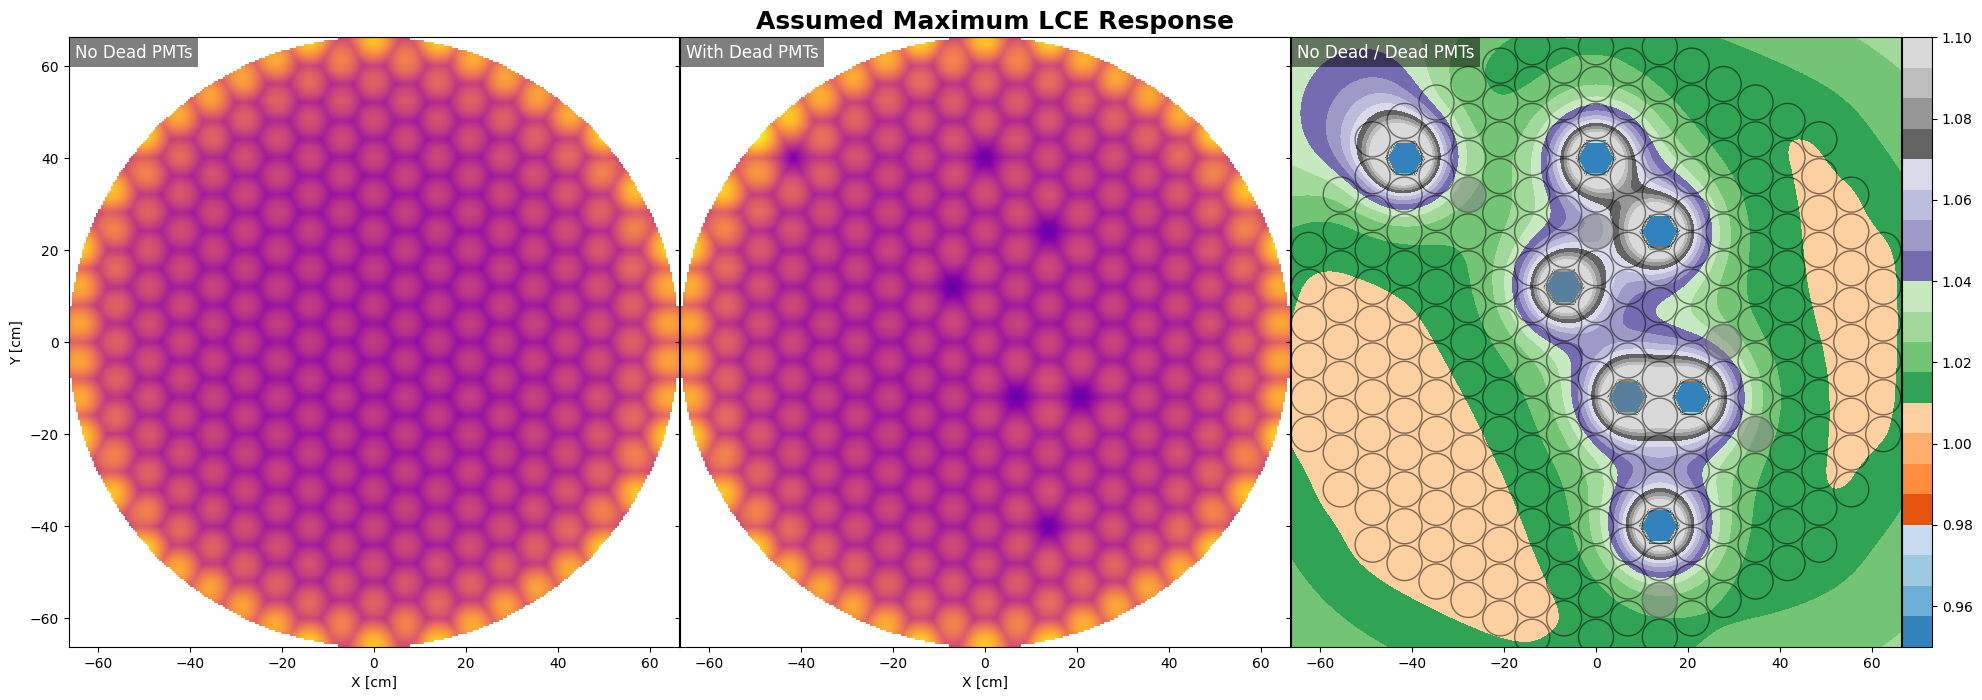

In [197]:
# Make order Plots
from scipy.stats import binned_statistic_2d
tmp_bmap = np.linalg.norm(xy_grid,axis=-1) < 66.4

fig, ax = plt.subplots(1,4, figsize=(20,6.92), sharey=True, gridspec_kw={'wspace': 0, 'width_ratios': [1, 1,1,0.1]})

ax = ax.flatten()
fig.subplots_adjust(wspace=0)

vmin = min(max_without_dead.min(), max_with_dead.min())  # Global minimum
vmax = max(max_with_dead.max(), max_without_dead.max())  # Global maximum

i=0
# Some points mess with color scale for first order
stat, x_edges, y_edges, _ = binned_statistic_2d(
    xy_grid[tmp_bmap,0], xy_grid[tmp_bmap,1], max_without_dead[tmp_bmap], statistic='median', bins=300
)

im = ax[i].imshow(
    stat.T,              # Transpose to align correctly with axes
    origin='lower',      # Align the origin to the bottom-left
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],  # Set axis limits
    aspect='equal',       # Adjust aspect ratio
    cmap='plasma',       # Choose a colormap
    vmin=vmin, vmax=vmax
)
ax[i].set_xlabel('X [cm]')
ax[i].set_ylabel('Y [cm]')

ax[i].text(
    0.01, 0.99,                   # Position (x, y) in axes coordinates (0 to 1)
    f'No Dead PMTs',                # Text to display
    transform=ax[i].transAxes,       # Use axes coordinates
    fontsize=12,                  # Font size
    va='top', ha='left',          # Alignment
    color='white',                # Text color (optional, depending on background)
    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')  # Background box
)
ax[i].set_xlim(-66.4,66.4)
#ax[i].set_ylim(-66.4,66.4)

i=1
# Some points mess with color scale for first order
stat, x_edges, y_edges, _ = binned_statistic_2d(
    xy_grid[tmp_bmap,0], xy_grid[tmp_bmap,1], max_with_dead[tmp_bmap], statistic='median', bins=300
)

im = ax[i].imshow(
    stat.T,              # Transpose to align correctly with axes
    origin='lower',      # Align the origin to the bottom-left
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],  # Set axis limits
    aspect='equal',       # Adjust aspect ratio
    cmap='plasma',       # Choose a colormap
    vmin=vmin, vmax=vmax
)
ax[i].set_xlabel('X [cm]')

ax[i].text(
    0.01, 0.99,                   # Position (x, y) in axes coordinates (0 to 1)
    f'With Dead PMTs',                # Text to display
    transform=ax[i].transAxes,       # Use axes coordinates
    fontsize=12,                  # Font size
    va='top', ha='left',          # Alignment
    color='white',                # Text color (optional, depending on background)
    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')  # Background box
)
ax[i].set_xlim(-66.4,66.4)
#ax[i].set_ylim(-66.4,66.4)
#cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
#plt.colorbar(im, ax= cbar_ax, label='Median LCE Response', location='right', fraction=0.05, pad=0.1)

i=2
cmap = 'tab20c'
scale_map = (max_with_dead/max_without_dead).reshape((grid_points,grid_points))
im2 = ax[i].imshow((max_with_dead/max_without_dead).reshape((grid_points,grid_points)), origin='lower', aspect='equal', extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],cmap=cmap,vmax=1.1,vmin=0.95,)
ax[i].text(
    0.01, 0.99,                   # Position (x, y) in axes coordinates (0 to 1)
    f'No Dead / Dead PMTs',                # Text to display
    transform=ax[i].transAxes,       # Use axes coordinates
    fontsize=12,                  # Font size
    va='top', ha='left',          # Alignment
    color='white',                # Text color (optional, depending on background)
    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')  # Background box
)
ax[i].set_xlim(-66.4,66.4)

plot_pmt_circles(ax=ax[i], pmt_pos=pmt_pos_top, dead_pmts=dead_pmts, alpha=0.5)

cbar = fig.colorbar(im2, ax=ax[i+1], fraction=1)
ax[i+1].remove()

plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.tight_layout()
fig.suptitle('Assumed Maximum LCE Response', fontsize=18, fontweight="bold")
plt.show()


In [282]:
tmp_bmap = response_orders[:,0] < 0.2
hist_fine, _, y_extent = np.histogram2d(pos_rot[1][tmp_bmap], pos_rot[0][tmp_bmap], bins=[np.linspace(-66.4, 66.4, grid_points+1),np.linspace(-66.4, 66.4, grid_points+1)])

x_bins = np.digitize(pos_rot[0,:], x) - 1  
y_bins = np.digitize(pos_rot[1,:], y) - 1

tmp_bmap = response_orders[:,0] < 0.2
tmp_bmap &= np.linalg.norm(pos, axis=-1) < 55

scaled_response = response_orders[tmp_bmap,0] * scale_map[y_bins,x_bins][tmp_bmap]

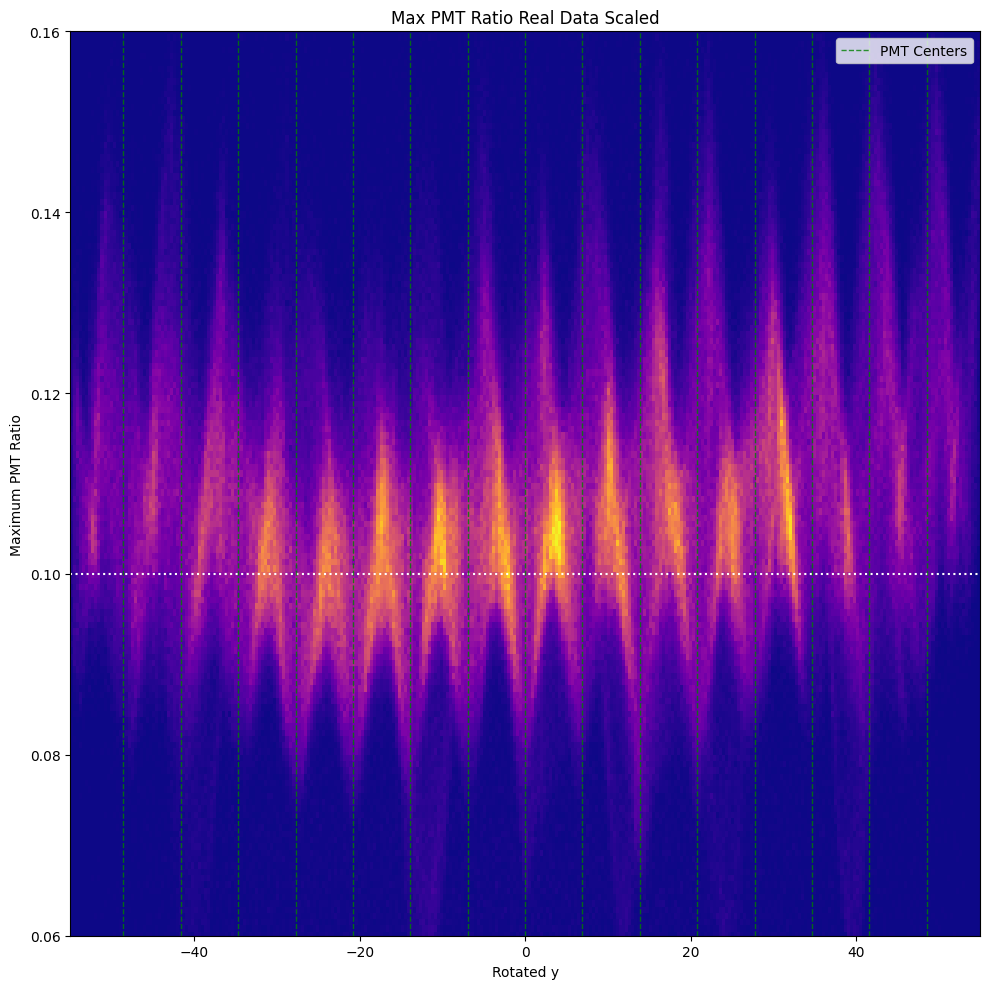

In [284]:
# Plot Mxa PMT as rotated y cross section
"""
Not very usefull but we would expect the outer three PMT peaks to Have a similar response
"""


fig, axes = plt.subplots(1,1, figsize=(10, 10))


ax =axes
i=0
ax.hist2d(pos_rot[1][tmp_bmap], scaled_response, bins = 300, cmap = 'plasma')
ax.set_title("Max PMT Ratio Real Data Scaled")
ax.set_xlabel("Rotated y")
ax.set_ylabel("Maximum PMT Ratio")
ax.set_ylim(0.06,0.16)
ax.axvline(unique_pmt_y[0], c='g',linestyle='--', linewidth=1,alpha=0.8,label='PMT Centers')
ax.axhline(0.10, c='w', linestyle='dotted')
for i in unique_pmt_y[1:]:
    ax.axvline(i, c='g',linestyle='--', linewidth=1,alpha=0.8)
ax.legend()

ax.legend()

plt.tight_layout()

## Maximum PMT Ratio and Event Position

Do this in two ways 

- Radial LCE, check Maximum PMT Ratio as a function of space 

- Toy model for photon flight -> Bin incidence Get maximum Ratio TODO Run on Big PC overnight or optimize

In [285]:
# Using Radial LCE

grid_points = int(1e3)
x = np.linspace(-66.4, 66.4, grid_points)
y = np.linspace(-66.4, 66.4, grid_points)

# Create meshgrid
x_grid, y_grid = np.meshgrid(x, y)

# Combine x and y into a single array of points
xy_grid = np.column_stack([x_grid.ravel(), y_grid.ravel()])

maxPMTRatio = np.full(xy_grid.shape[0], np.nan)
maxPMTRatio2 = np.full(xy_grid.shape[0], np.nan)
# And remove invalid 
bmask = np.sum(xy_grid**2, axis = -1) < 66.4**2
xy_grid = xy_grid[bmask]

radial_patterns.get_layer('i0').set_weights([np.ones_like(i0s)]) 
maxPMTRatio2[bmask] = np.max(radial_patterns.predict(xy_grid),axis=-1)
radial_patterns.get_layer('i0').set_weights([i0s]) 
maxPMTRatio[bmask] = np.max(radial_patterns.predict(xy_grid),axis=-1)


24493/24493 [==============================] - 27s 1ms/step


In [286]:
# Rotate System 
angle = np.radians(30)  # Convert angle to radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rot_grid_x, rot_grid_y = np.dot(rotation_matrix, np.vstack((xy_grid[:,0], xy_grid[:,1])))

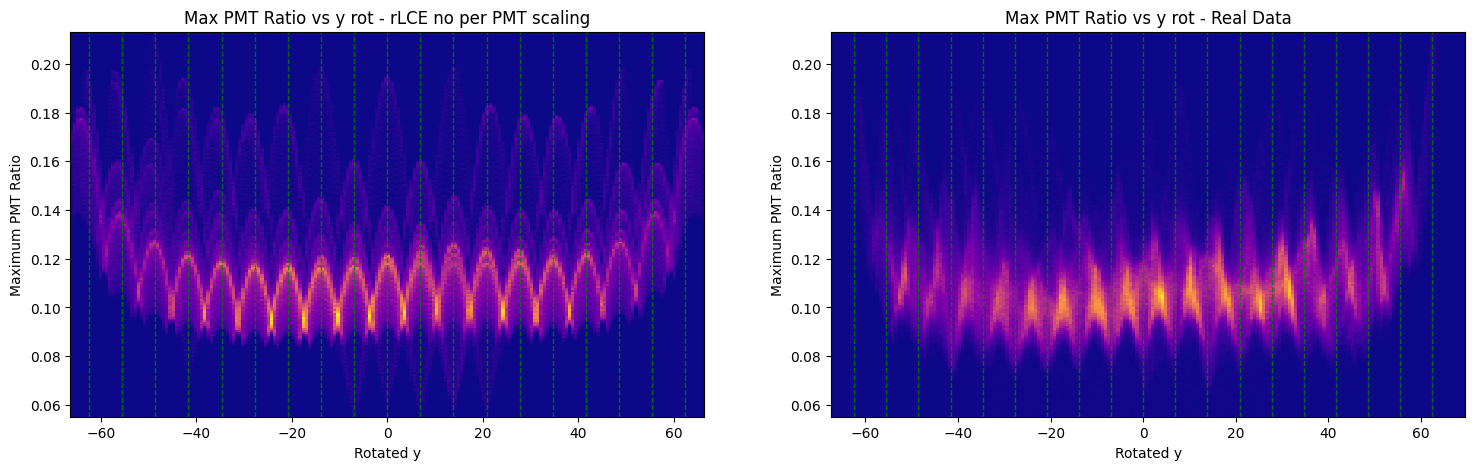

In [295]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
ax =axes[0]
ax.hist2d(rot_grid_y, maxPMTRatio2[bmask], bins = 200, cmap = 'plasma')
ax.set_title("Max PMT Ratio vs y rot - rLCE no per PMT scaling")
ax.set_xlabel("Rotated y")
ax.set_ylabel("Maximum PMT Ratio")

ax.axvline(unique_pmt_y[0], c='g',linestyle='--', linewidth=1,alpha=0.8,label='PMT Centers')
for i in unique_pmt_y[1:]:
    ax.axvline(i, c='g',linestyle='--', linewidth=1,alpha=0.8)

ax =axes[1]

pos = np.array(all_data_df['position'].to_list())
rot_grid_x, rot_grid_y_real =np.dot(rotation_matrix, np.vstack((pos[:,0], pos[:,1])))
maxPMTRatio_real = np.array(all_data_df['s2_area_per_channel'].to_list())
maxPMTRatio_real = (maxPMTRatio_real/maxPMTRatio_real.sum(axis=-1)[:,np.newaxis]).max(axis=-1)

y_min, y_max = axes[0].get_ylim() 

real_crop = (maxPMTRatio_real < y_max) & (maxPMTRatio_real > y_min)

ax.hist2d(rot_grid_y_real[real_crop], maxPMTRatio_real[real_crop], bins = 200, cmap = 'plasma')
ax.set_title("Max PMT Ratio vs y rot - Real Data")
ax.set_xlabel("Rotated y")
ax.set_ylabel("Maximum PMT Ratio")
ax.axvline(unique_pmt_y[0], c='g',linestyle='--', linewidth=1,alpha=0.8,label='PMT Centers')
for i in unique_pmt_y[1:]:
    ax.axvline(i, c='g',linestyle='--', linewidth=1,alpha=0.8)

plt.show()

## Maximum PMT Ratio and Chi squared - Part 1 : Sim grid and LCE - Failed why in the world did it fail

The goal here is to show that Maximum PMT Ratio is directly related to variance in chi squared over a certain predefined area

Such that reconstruction models will generally prefer placing models closer to PMT centers or equivalently along the PMT Center variation lines 


For some reason I cant get flow to predict the positions of LCE based patterns, pulling MC data at the moment use this to show

In [105]:
"""
Genreate grid and pattersn from rLCE and NN

use flow & MLP to reconstruct positions and see where the positoons end up

If positions are reconstructed similar to max pmt ratio we have that the three variables are related with a 
bias of high ratio centers having better reconstruction and the points at maximum being favored 

If this is not the case might still be able to use low loss events and show that the further one goes from PMT centers the worse reconstruction is
"""

'\nGenreate grid and pattersn from rLCE and NN\n\nuse flow & MLP to reconstruct positions and see where the positoons end up\n\n'

In [7]:
# Generate Grid

grid_points = int(1e1)
x = np.linspace(-66.4, 66.4, grid_points)
y = np.linspace(-66.4, 66.4, grid_points)

# Create meshgrid
x_grid, y_grid = np.meshgrid(x, y)

# Combine x and y into a single array of points
xy_grid = np.column_stack([x_grid.ravel(), y_grid.ravel()])

# And remove invalid 
bmask = np.sum(xy_grid**2, axis = -1) < 66.45**2
xy_grid = xy_grid[bmask]

# For some reason its being difficult so lets source appropiate sum areas
from scipy.spatial import cKDTree
tree = cKDTree(np.array(all_data_df['position'].to_list()))
_, indices = tree.query(xy_grid)

In [8]:
# Generate Patterns
patterns_rad = radial_patterns.predict(xy_grid)
patterns_nn = model_pattern.predict(xy_grid)

2/2 [==============================] - 0s 3ms/step


array([[1.78902207e+04],
       [1.99631465e+04],
       [1.38683609e+05],
       [3.91004834e+03],
       [5.35194453e+04],
       [1.89154480e+02],
       [2.47454492e+03],
       [7.26984609e+04],
       [7.78329453e+04],
       [8.69565332e+03],
       [5.40771729e+03],
       [5.08632373e+03],
       [4.88367139e+03],
       [5.47473242e+04],
       [4.08954414e+04],
       [5.93530029e+03],
       [8.26710449e+03],
       [9.00488750e+04],
       [1.00336212e+02],
       [5.98149902e+03],
       [4.54744531e+03],
       [3.87383691e+03],
       [5.79221582e+03],
       [5.34558691e+03],
       [7.82201367e+03],
       [5.61107227e+03],
       [7.00602539e+03],
       [2.77368500e+05],
       [4.02816455e+03],
       [5.24995312e+03],
       [1.17209102e+05],
       [5.97836133e+03],
       [4.54181738e+03],
       [5.27750000e+03],
       [6.73467125e+05],
       [3.74554766e+04],
       [1.52474248e+04],
       [4.53429004e+03],
       [1.40259203e+05],
       [1.69433398e+04],


In [22]:
# Load Flow Model and predict positons
fname = '/Code/posrec_models_from_straxen/flow_20240730.tar.gz'
import tarfile 
def open_jax_model(model_path: str, **kwargs):
    # Copied directly from straxen including the two functions below (modified where required)
    # Nested import to reduce loading time of import straxen as it's not
    # a base requirement
    from jax import export

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No file at {model_path}")
    # Extract required parameters from kwargs
    n_poly = kwargs["n_poly"]
    sig = kwargs["sig"]

    # Open the tar file and extract the requested model
    with tarfile.open(model_path, "r") as f:
        names = f.getnames()

        # Construct the filename based on n_poly and sig
        filename = f"{int(n_poly):02d}_{float(sig) * 1000:3.0f}"

        # Check if the requested model exists in the tar file
        if filename not in names:
            raise ValueError("Requested model not in tarfile!")

        # Extract and read the serialized JAX object
        file_obj = f.extractfile(filename)
        assert file_obj is not None
        serialized_jax_object = file_obj.read()
    # Deserialize the JAX object and return its callable function
    return export.deserialize(serialized_jax_object).call
def vectorized_prediction_chunk(patterns, pred_function, N_chunk_max):
    N_entries = patterns.shape[0]
    if N_entries > N_chunk_max:
        raise ValueError("Chunk greater than max size")
    else:
        inputs = np.zeros((N_chunk_max, pmt_pos_top.shape[0]+1))
        inputs[:N_entries] = patterns
        xy, contour = pred_function(inputs)
        return xy[:N_entries], contour[:N_entries]
def prediction_loop(patterns, pred_function, N_chunk_max=4096):
    N_entries = patterns.shape[0]
    # If the number of entries is within the chunk limit, process in one step
    if N_entries <= N_chunk_max:
        xy, _ = vectorized_prediction_chunk(patterns, pred_function, N_chunk_max)
        return [xy]  # Return as a single-element list for consistency
    N_chunks = N_entries // N_chunk_max
    xy_list = []
    # Process chunks
    for i in range(N_chunks):
        xy, _ = vectorized_prediction_chunk(
            patterns[i * N_chunk_max : (i + 1) * N_chunk_max], pred_function, N_chunk_max
        )
        xy_list.append(xy)

    # Process remaining entries, if any
    if N_chunks * N_chunk_max < N_entries:
        xy, _ = vectorized_prediction_chunk(
            patterns[N_chunks * N_chunk_max :], pred_function, N_chunk_max
        )
        xy_list.append(xy)
    return np.concatenate(xy_list, axis=0)

flow_model = open_jax_model(fname, n_poly=32, sig=0.393)
log_area_scale = 10

# Prep data
with np.errstate(divide="ignore", invalid="ignore"):
    total_top_areas = np.array(all_data_df.s2_area_per_channel.iloc[indices].to_list()).sum(axis=-1)[:,np.newaxis]
    area_per_channel_top = np.zeros((patterns_rad.shape[0], 253))
    area_per_channel_top[:,not_dead_pmts] = patterns_rad
    flow_data = np.concatenate(
        [
            area_per_channel_top / total_top_areas,  # Normalize areas per channel
            np.log(total_top_areas) / log_area_scale,  # Log-scale transformation
        ],
        axis=1,
    )
pos_pred_rad =  prediction_loop(flow_data, flow_model)[0]

# Prep data
with np.errstate(divide="ignore", invalid="ignore"):
    total_top_areas = np.array(all_data_df.s2_area_per_channel.iloc[indices].to_list()).sum(axis=-1)[:,np.newaxis]
    area_per_channel_top = np.zeros((patterns_nn.shape[0], 253))
    area_per_channel_top[:,not_dead_pmts] = patterns_nn
    flow_data = np.concatenate(
        [
            (area_per_channel_top / total_top_areas).astype('float32'),  # Normalize areas per channel
            np.log(total_top_areas) / log_area_scale,  # Log-scale transformation
        ],
        axis=1,
    )
pos_pred_nn =  prediction_loop(flow_data, flow_model)[0]


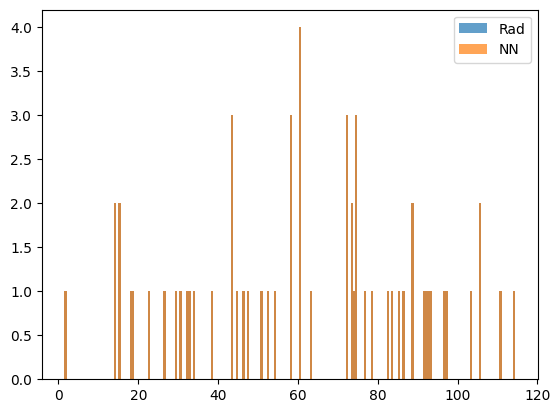

In [23]:
# Lets see differences  TODO Fuck it use MLP+
plt.hist(np.linalg.norm(xy_grid-pos_pred_rad, axis=-1),alpha=0.7, label='Rad', bins=200)
plt.hist(np.linalg.norm(xy_grid-pos_pred_nn, axis=-1), alpha=0.7, label='NN',bins=200)
plt.legend()
plt.show()

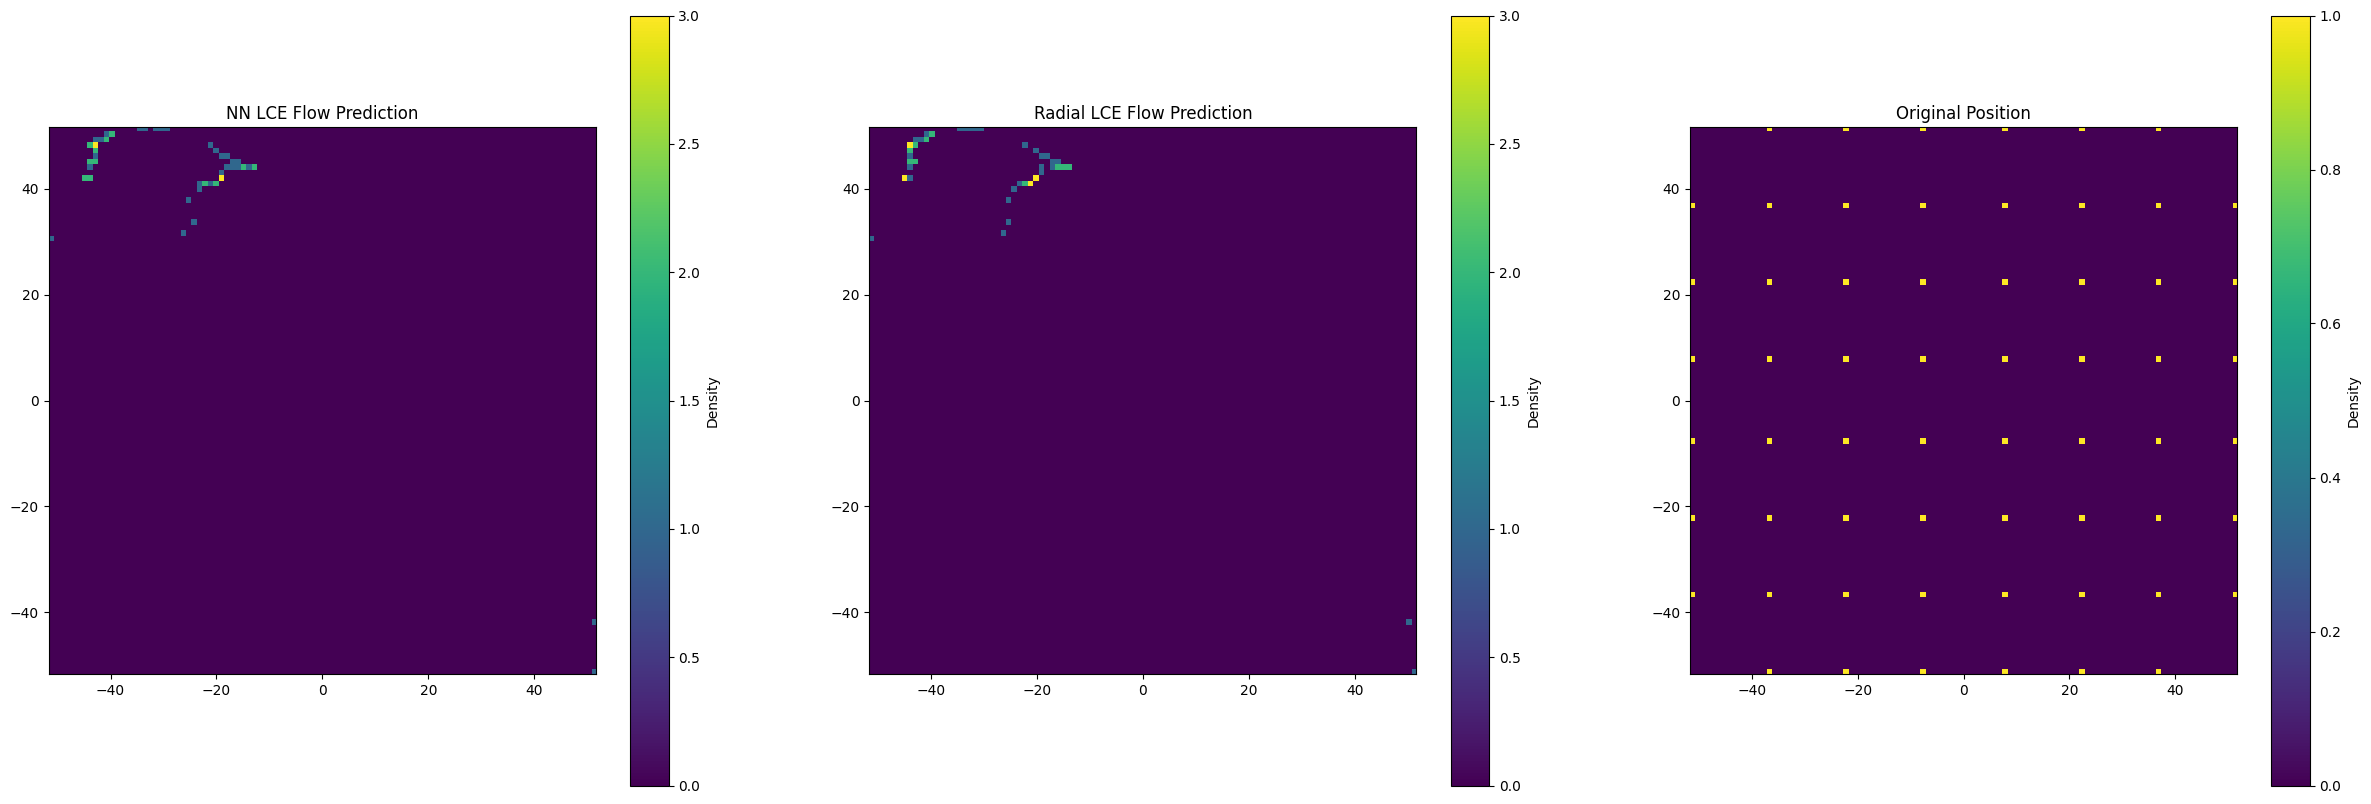

In [24]:
# Make 2d Density plot I tihnk I showed what I wanted - For flow needed to scale top area to 1e5
bins =100
nn_pred_dens, x_edges, y_edges = np.histogram2d(pos_pred_nn[~np.isnan(pos_pred_nn).any(axis=-1),0], pos_pred_nn[~np.isnan(pos_pred_nn).any(axis=-1),1], bins=bins )
rad_pred_dens, x_edges, y_edges = np.histogram2d(pos_pred_rad[:,0], pos_pred_rad[:,1], bins=bins )
orig_dens, x_edges, y_edges = np.histogram2d(xy_grid[:,0], xy_grid[:,1], bins=bins )


fig, ax = plt.subplots(1,3,figsize=(30,10))

i=0
im = ax[i].imshow(nn_pred_dens.T, origin='lower', extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]))
ax[i].set_title('NN LCE Flow Prediction')
plt.colorbar(im, ax=ax[i],label='Density')
i=1
im = ax[i].imshow(rad_pred_dens.T, origin='lower', extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]))
ax[i].set_title('Radial LCE Flow Prediction')
plt.colorbar(im, ax=ax[i],label='Density')
i=2
im = ax[i].imshow(orig_dens.T, origin='lower', extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]))
ax[i].set_title('Original Position')
plt.colorbar(im, ax=ax[i],label='Density')

## Maximum PMT Ratio and Chi squared - Part 2 : Use MC


In [6]:
mc_path = "/Code/processed_data/MC/s2_hitpatterns"
mc_files = [ os.path.join(mc_path, i) for i in os.listdir(mc_path) if '.hdf5' in i ]

In [7]:
hitpatterns = []
interface_electrons = []
interface_x = []
interface_y = []
mc_electrons = []
mc_x = []
mc_y = []
for i in mc_files:
    with h5py.File(i) as f_:
        hitpatterns.append(f_['hitpatterns'][:])
        interface_electrons.append(f_['interface_electrons'][:])
        interface_x.append(f_['interface_x'][:])
        interface_y.append(f_['interface_y'][:])
        mc_electrons.append(f_['mc_electrons'][:])
        mc_x.append(f_['mc_x'][:])
        mc_y.append(f_['mc_y'][:])

hitpatterns = np.concatenate(hitpatterns,axis=0)
interface_electrons = np.concatenate(interface_electrons,axis=0)
interface_x = np.concatenate(interface_x,axis=0)
interface_y = np.concatenate(interface_y,axis=0)
mc_electrons = np.concatenate(mc_electrons,axis=0)
mc_x = np.concatenate(mc_x,axis=0)
mc_y = np.concatenate(mc_y,axis=0)

In [69]:
hitpatterns.shape

(3093067, 253)

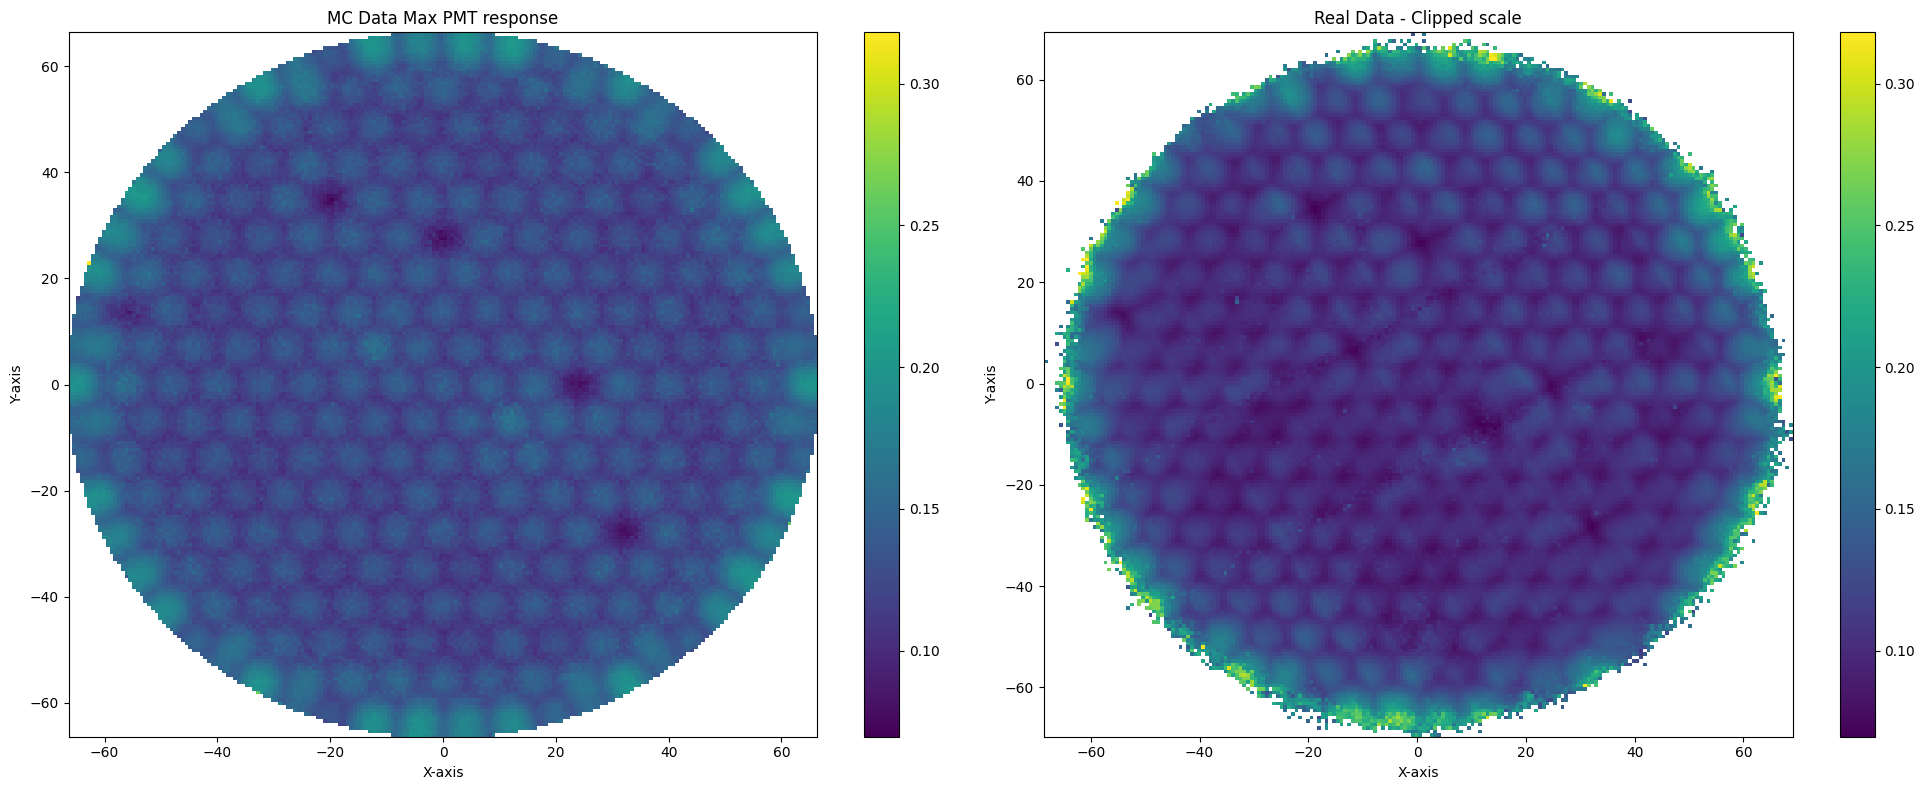

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

max_LCE = (hitpatterns / hitpatterns[:,not_dead_pmts].sum(axis=-1)[:,None]).max(axis=-1)
maxPMTRatio, x_grid, y_grid, _= scipy.stats.binned_statistic_2d(mc_x, mc_y, max_LCE,bins=200)

c = ax[0].pcolormesh(x_grid, y_grid, maxPMTRatio, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_title("MC Data Max PMT response")
ax[0].set_xlabel("X-axis")
ax[0].set_ylabel("Y-axis")

tmp = np.array(all_data_df['s2_area_per_channel'].to_list())
max_LCE = (tmp / tmp.sum(axis=-1)[:,None]).max(axis=-1)
maxPMTRatio_real, x_grid, y_grid, _= scipy.stats.binned_statistic_2d(all_data_df['s2_x'], all_data_df['s2_y'], max_LCE,bins=200)

c = ax[1].pcolormesh(x_grid, y_grid, maxPMTRatio_real, shading='auto', cmap='viridis', vmin=np.nanmin(maxPMTRatio) , vmax=np.nanmax(maxPMTRatio))
fig.colorbar(c, ax=ax[1])
ax[1].set_title("Real Data - Clipped scale")
ax[1].set_xlabel("X-axis")
ax[1].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()

In [8]:
hitpatterns.shape

(3093067, 253)

In [25]:
# Reconstruct MC data 

fname = '/Code/posrec_models_from_straxen/flow_20240730.tar.gz'
import tarfile 
def open_jax_model(model_path: str, **kwargs):
    # Copied directly from straxen including the two functions below (modified where required)
    # Nested import to reduce loading time of import straxen as it's not
    # a base requirement
    from jax import export

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No file at {model_path}")
    # Extract required parameters from kwargs
    n_poly = kwargs["n_poly"]
    sig = kwargs["sig"]

    # Open the tar file and extract the requested model
    with tarfile.open(model_path, "r") as f:
        names = f.getnames()

        # Construct the filename based on n_poly and sig
        filename = f"{int(n_poly):02d}_{float(sig) * 1000:3.0f}"

        # Check if the requested model exists in the tar file
        if filename not in names:
            raise ValueError("Requested model not in tarfile!")

        # Extract and read the serialized JAX object
        file_obj = f.extractfile(filename)
        assert file_obj is not None
        serialized_jax_object = file_obj.read()
    # Deserialize the JAX object and return its callable function
    return export.deserialize(serialized_jax_object).call
def vectorized_prediction_chunk(patterns, pred_function, N_chunk_max):
    N_entries = patterns.shape[0]
    if N_entries > N_chunk_max:
        raise ValueError("Chunk greater than max size")
    else:
        inputs = np.zeros((N_chunk_max, pmt_pos_top.shape[0]+1))
        inputs[:N_entries] = patterns
        xy, contour = pred_function(inputs)
        return xy[:N_entries], contour[:N_entries]
def prediction_loop(patterns, pred_function, N_chunk_max=4096):
    N_entries = patterns.shape[0]
    # If the number of entries is within the chunk limit, process in one step
    if N_entries <= N_chunk_max:
        xy, _ = vectorized_prediction_chunk(patterns, pred_function, N_chunk_max)
        return [xy]  # Return as a single-element list for consistency
    N_chunks = N_entries // N_chunk_max
    xy_list = []
    # Process chunks
    for i in range(N_chunks):
        xy, _ = vectorized_prediction_chunk(
            patterns[i * N_chunk_max : (i + 1) * N_chunk_max], pred_function, N_chunk_max
        )
        xy_list.append(xy)

    # Process remaining entries, if any
    if N_chunks * N_chunk_max < N_entries:
        xy, _ = vectorized_prediction_chunk(
            patterns[N_chunks * N_chunk_max :], pred_function, N_chunk_max
        )
        xy_list.append(xy)
    return np.concatenate(xy_list, axis=0)
# Prep data
flow_model = open_jax_model(fname, n_poly=32, sig=0.393)
log_area_scale = 10
with np.errstate(divide="ignore", invalid="ignore"):
    total_top_areas = hitpatterns.sum(axis=-1)[:,np.newaxis]
    area_per_channel_top = np.zeros((hitpatterns.shape[0], 253))
    area_per_channel_top[:,:] = hitpatterns
    flow_data = np.concatenate(
        [
            area_per_channel_top / total_top_areas,  # Normalize areas per channel
            np.log(total_top_areas) / log_area_scale,  # Log-scale transformation
        ],
        axis=1,
    )
pos_pred_mc =  prediction_loop(flow_data, flow_model)

In [17]:
# Rotate System 
max_LCE = (hitpatterns / hitpatterns.sum(axis=-1)[:,None]).max(axis=-1)
angle = np.radians(30)  # Convert angle to radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rot_grid_x, rot_grid_y = np.dot(rotation_matrix, np.vstack((mc_x, mc_y)))
# Fucks up scaling a lil 
bmask = max_LCE < 0.22

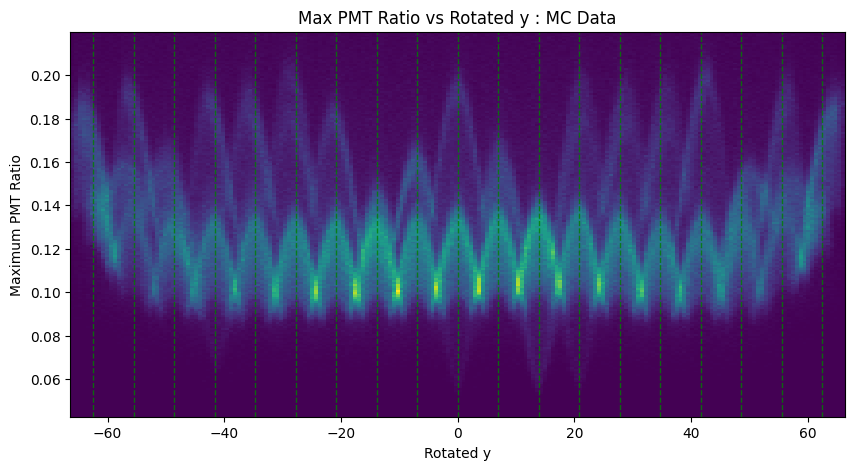

In [20]:
plt.figure(figsize=(10,5))
plt.hist2d(rot_grid_y[bmask], max_LCE[bmask], bins = 200)
ax= plt.gca()
ax.axvline(unique_pmt_y[0], c='g',linestyle='--', linewidth=1,alpha=0.8)
for i in unique_pmt_y[1:]:
    ax.axvline(i, c='g',linestyle='--', linewidth=1,alpha=0.8)
plt.title("Max PMT Ratio vs Rotated y : MC Data")
plt.xlabel("Rotated y")
plt.ylabel("Maximum PMT Ratio")
#plt.ylim(0.05,0.3)
plt.show()

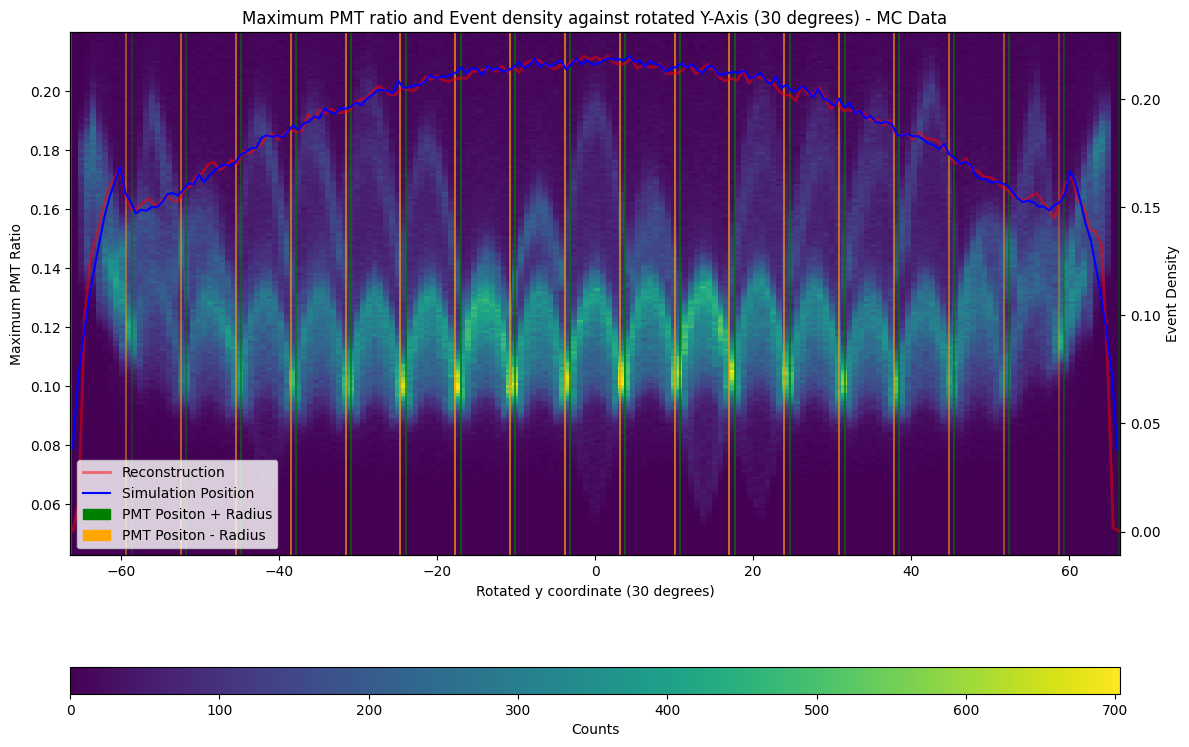

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Rotate System
angle = np.radians(30)  # Convert angle to radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rotated_positions = np.dot(rotation_matrix, pos_pred_mc.T)
rot_grid_x, rot_grid_y = rotated_positions[0], rotated_positions[1]

# Calculate density for mc_x and mc_y
rotated_positions = np.dot(rotation_matrix, np.array([mc_x, mc_y]))
mc_x_rot, mc_y_rot = rotated_positions[0], rotated_positions[1]
mc_y_density, mc_y_bins = np.histogram(mc_y_rot, bins=200, density=True)


mc_y_centers = (mc_y_bins[:-1] + mc_y_bins[1:]) / 2

# Main Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the 2D histogram
hist = ax1.hist2d(rot_grid_y[bmask], max_LCE[bmask], bins=200, cmap='viridis')

# Add colorbar for the histogram
cbar = plt.colorbar(hist[3], ax=ax1, orientation='horizontal', aspect=40)
cbar.set_label('Counts')

# Customize the primary axis
ax1.set_xlabel('Rotated y coordinate (30 degrees)')
ax1.set_ylabel('Maximum PMT Ratio')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Calculate the density of `rot_grid_y`
y_hist, y_bins = np.histogram(rot_grid_y, bins=200, density=True)
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers

# Scale the density to match the secondary axis range
y_hist_scaled = (y_hist / y_hist.max()) * ax1.get_ylim()[1]

# Plot the scaled density line on the secondary y-axis
ax2.plot(y_bin_centers, y_hist_scaled, color='red', alpha=0.5, linewidth=2, label='Reconstruction')
ax2.set_ylabel('Event Density')
ax2.tick_params(axis='y')
ax2.plot(mc_y_centers, (mc_y_density / mc_y_density.max()) * ax1.get_ylim()[1], color='blue', label='Simulation Position')



# Add legend for secondary y-axis
handles, labels = ax2.get_legend_handles_labels()

for i in rot_pmt_y:
    ax1.axvline(i+pmt_radius, c='green',lw=0.1)
    ax1.axvline(i-pmt_radius, c='orange',lw=0.1)

custom_patch = mpatches.Patch(color='green', label='PMT Positon + Radius')
handles.append(custom_patch)  # Add the custom entry
labels.append('PMT Positon + Radius')  # Add corresponding label
custom_patch = mpatches.Patch(color='orange', label='PMT Positon - Radius')
handles.append(custom_patch)  # Add the custom entry
labels.append('PMT Positon - Radius')  # Add corresponding label
# Add legend to the plot
ax2.legend(handles=handles, labels=labels, loc='lower left')

ax2.legend(handles=handles, labels=labels, loc='lower left')
ax1.set_xlim(-66.4,66.4)
# Density of mc_y
#ax4.set_xlabel('Coordinate')
#ax4.set_ylabel('Density')
#ax4.set_title('Density of mc_y')
#ax4.legend()
#
plt.title('Maximum PMT ratio and Event density against rotated Y-Axis (30 degrees) - MC Data')
plt.tight_layout()
plt.show()


###  TODO
I think the way to move on is:
- Write up the base note
    - Talk about: The rLCE Problem, the Geometric Effects, that the simple anode shadow model does not solve this problem
    - Also talk about likely correlation between MaxPMT and Density in observed data 
        - Mention believe that this may be due to algos being inherently more sensitive to the maximum response than the weighted - But find way to back up this isnt making much sense right now
- Use the MC Data and Symbolic Regression to fit an alternate version of the Base radial LCE function
    - I think we can make it start of from that though
- Then start fitting more functions based on different variables
    - Anode mesh distance
    - Perpendicular wire distance
    - Wall Distance : Maybe this one first
    - And if none of teh above work x and y rot -> Hoping that we will get some usefull information about this

In [127]:
grid_points = int(200)
x = np.linspace(-66.4, 66.4, grid_points)
y = np.linspace(-66.4, 66.4, grid_points)
x_grid_pred, y_grid_pred = np.meshgrid(x, y)
xy_grid = np.column_stack([x_grid_pred.ravel(), y_grid_pred.ravel()])

# Predict Maximum Response Values
hitpattenr_tmp = radial_patterns.predict(xy_grid)
max_pred = np.max(hitpattenr_tmp,axis=-1)
max_pred_which = np.argmax(hitpattenr_tmp,axis=-1)
max_pred=max_pred.reshape(x_grid_pred.shape)
max_pred_which=max_pred_which.reshape(x_grid_pred.shape)


hitpattenr_tmp = model_pattern.predict(xy_grid)
max_nn = np.max(hitpattenr_tmp,axis=-1)
max_nn_which = np.argmax(hitpattenr_tmp,axis=-1)
max_nn=max_nn.reshape(x_grid_pred.shape)
max_nn_which=max_nn_which.reshape(x_grid_pred.shape)

max_nn_which[(x_grid_pred**2+y_grid_pred**2) >= 66.4**2] = -1

"""Real Data
from scipy.stats import mode
def mode_statistic(arr):
    if len(arr) == 0:  # Handle empty bins
        return np.nan
    return mode(arr, axis=None).mode

tmp = np.array(all_data_df['s2_area_per_channel'].to_list())
tmp = (tmp / tmp[:,not_dead_pmts].sum(axis=-1)[:,None])
max_LCE = tmp.max(axis=-1)
max_LCE_which = tmp.argmax(axis=-1)
maxPMTRatio_real, x_grid, y_grid, _= scipy.stats.binned_statistic_2d(all_data_df['s2_x'], all_data_df['s2_y'], max_LCE,bins=200)
maxPMTRatio_real_which, x_grid, y_grid, _= scipy.stats.binned_statistic_2d(all_data_df['s2_x'], all_data_df['s2_y'], max_LCE_which,bins=200, statistic=mode_statistic)"""



1250/1250 [==============================] - 3s 3ms/step


"Real Data\nfrom scipy.stats import mode\ndef mode_statistic(arr):\n    if len(arr) == 0:  # Handle empty bins\n        return np.nan\n    return mode(arr, axis=None).mode\n\ntmp = np.array(all_data_df['s2_area_per_channel'].to_list())\ntmp = (tmp / tmp[:,not_dead_pmts].sum(axis=-1)[:,None])\nmax_LCE = tmp.max(axis=-1)\nmax_LCE_which = tmp.argmax(axis=-1)\nmaxPMTRatio_real, x_grid, y_grid, _= scipy.stats.binned_statistic_2d(all_data_df['s2_x'], all_data_df['s2_y'], max_LCE,bins=200)\nmaxPMTRatio_real_which, x_grid, y_grid, _= scipy.stats.binned_statistic_2d(all_data_df['s2_x'], all_data_df['s2_y'], max_LCE_which,bins=200, statistic=mode_statistic)"

/tmp/ipykernel_166/3385316324.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20b', 20).colors


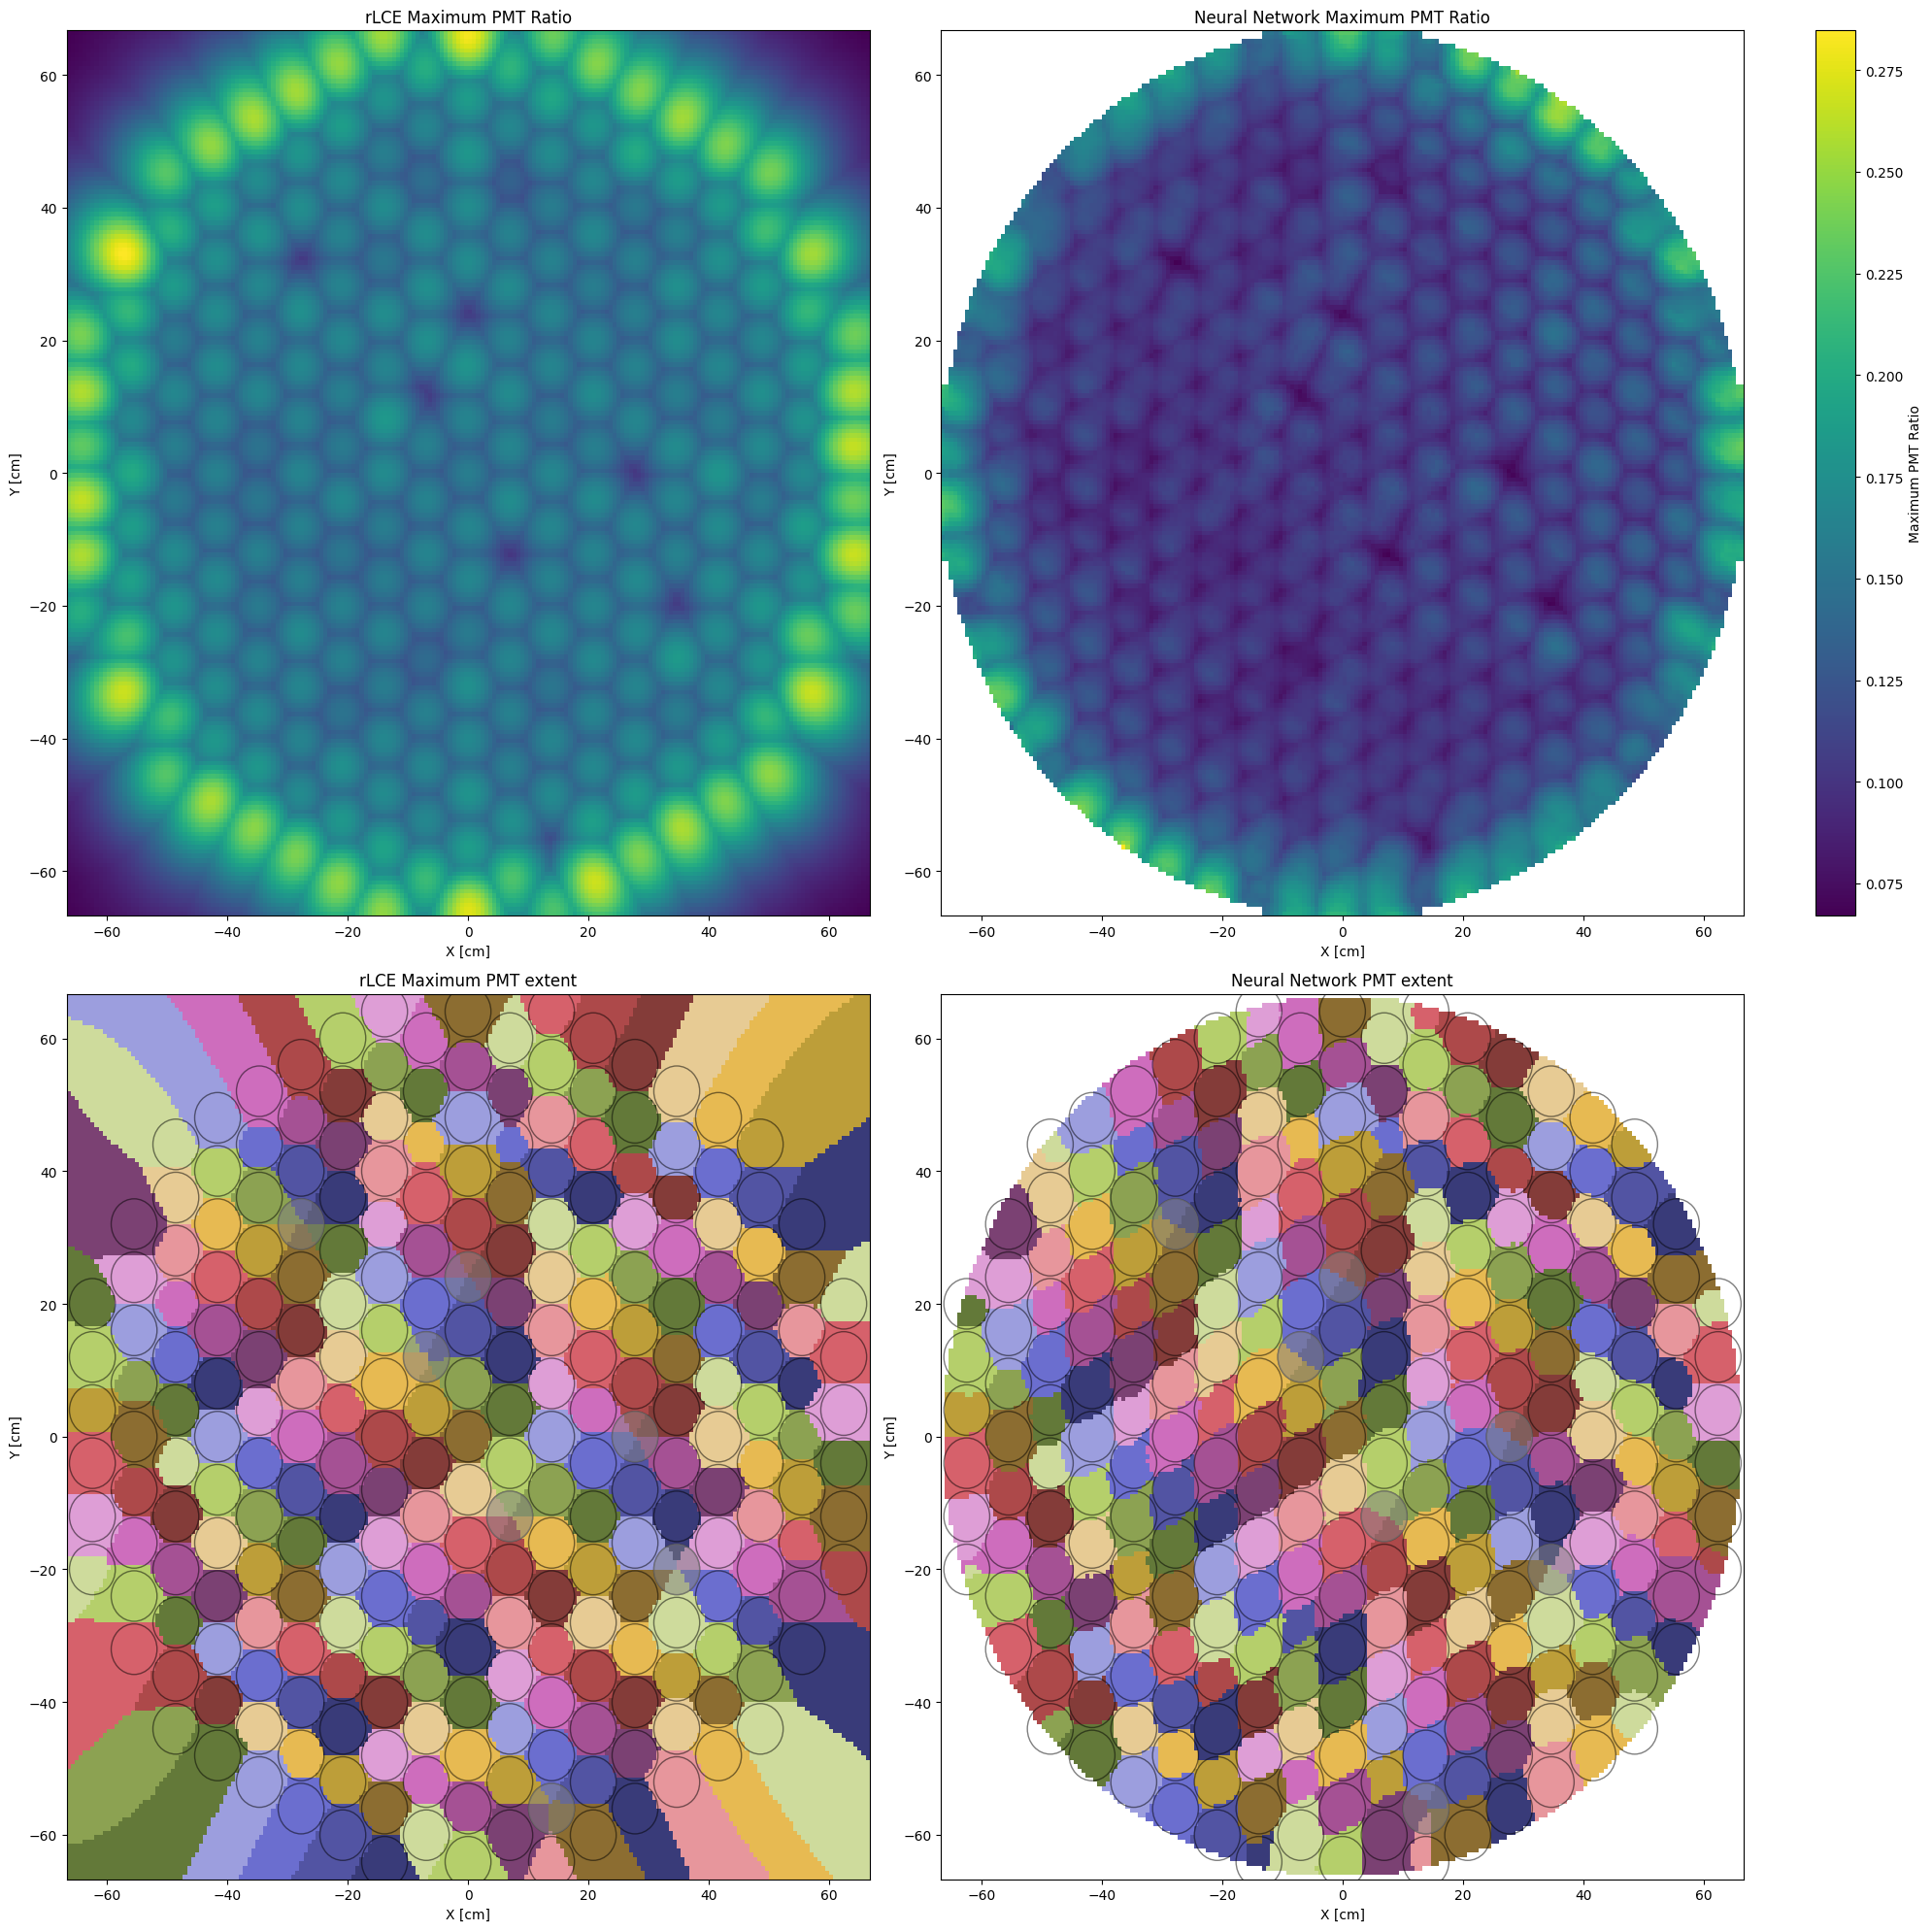

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

# Create a custom colormap
colors = plt.cm.get_cmap('tab20b', 20).colors
repeated_colors = np.tile(colors, (255 // len(colors) + 1, 1))[:255]
custom_cmap = ListedColormap(repeated_colors)

# Flexible layout with GridSpec
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.05])

# First row, first plot
ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(x_grid_pred, y_grid_pred, max_pred, shading='auto', cmap='viridis')
#fig.colorbar(c, ax=ax1)
ax1.set_title("rLCE Maximum PMT Ratio")
ax1.set_xlabel("X [cm]")
ax1.set_ylabel("Y [cm]")

# First row, second plot
ax2 = fig.add_subplot(gs[0, 1])
c2 = ax2.pcolormesh(x_grid_pred, y_grid_pred, max_nn, shading='auto', cmap='viridis',
                    vmin=np.nanmin(max_nn), vmax=np.nanmax(max_nn))
#fig.colorbar(c2, ax=ax2)
ax2.set_title("Neural Network Maximum PMT Ratio")
ax2.set_xlabel("X [cm]")
ax2.set_ylabel("Y [cm]")

# First row, third column - colorbar only
cbar_ax = fig.add_subplot(gs[0, 2])
cbar_img = fig.colorbar(c2, cax=cbar_ax, label='Maximum PMT Ratio')

# Second row, first plot
ax3 = fig.add_subplot(gs[1, 0])
ax3.pcolormesh(x_grid_pred, y_grid_pred, max_pred_which, shading='auto', cmap=custom_cmap)
ax3.set_title("rLCE Maximum PMT extent")
ax3.set_xlabel("X [cm]")
ax3.set_ylabel("Y [cm]")
plot_pmt_circles(ax=ax3, pmt_pos=pmt_pos_top, alpha=0.5, dead_pmts=dead_pmts)

# Second row, second plot
ax4 = fig.add_subplot(gs[1, 1])
ax4.pcolormesh(x_grid_pred, y_grid_pred, np.ma.masked_where(max_nn_which == -1, max_nn_which), shading='auto', cmap=custom_cmap)
ax4.set_title("Neural Network PMT extent")
ax4.set_xlabel("X [cm]")
ax4.set_ylabel("Y [cm]")
plot_pmt_circles(ax=ax4, pmt_pos=pmt_pos_top, alpha=0.5, dead_pmts=dead_pmts)

# Leave the second row, third column empty (no subplot added there)

plt.tight_layout()
plt.show()


In [46]:
tmp = np.array(all_data_df['s2_area_per_channel'].to_list())
tmp = (tmp / tmp[:,not_dead_pmts].sum(axis=-1)[:,None])
max_LCE = tmp.max(axis=-1)
bmap = (max_LCE < 0.2) & (max_LCE > 0.05)
pos = np.array(all_data_df['position'].to_list())
angle = np.radians(30)  # Convert angle to radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rot_grid_x, rot_grid_y = np.dot(rotation_matrix, np.vstack((pos[:,0], pos[:,1])))


In [47]:
rot_pmt_x, rot_pmt_y = np.dot(rotation_matrix, np.vstack((pmt_pos_top[:,-2], pmt_pos_top[:,-1])))
pmt_bounds = rot_pmt_y + pmt_radius

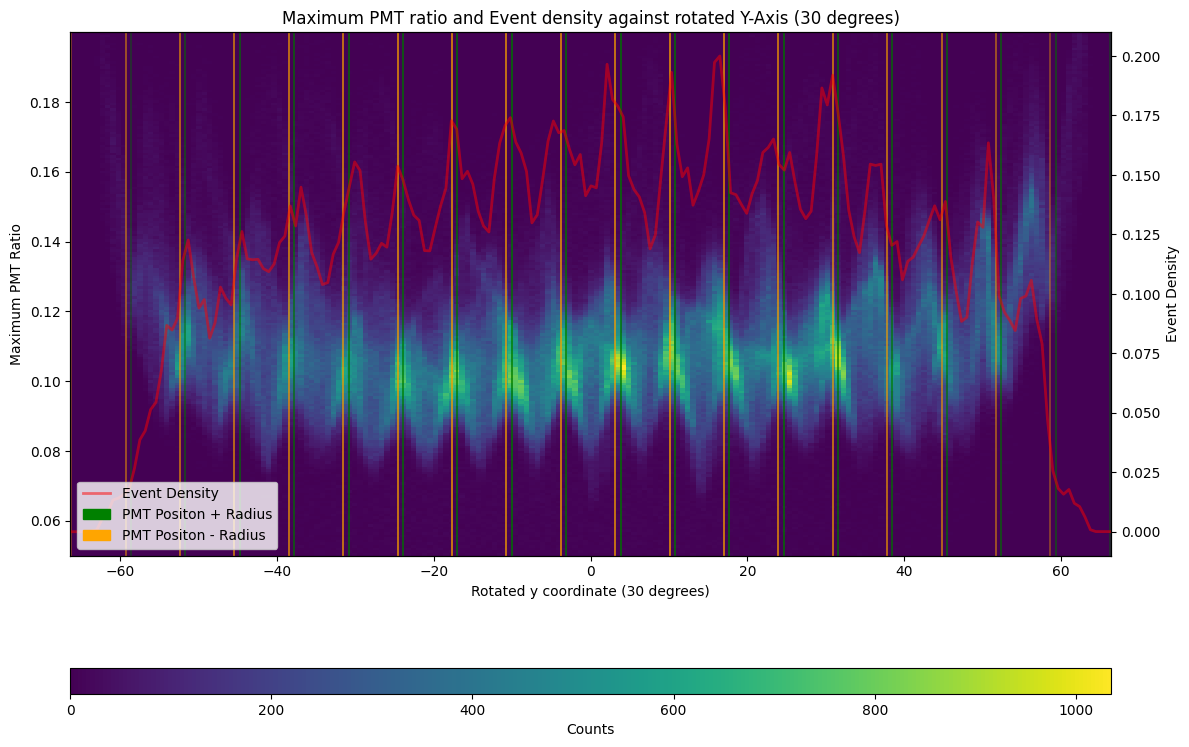

In [50]:
import matplotlib.patches as mpatches
# Create the 2D histogram
fig, ax1 = plt.subplots(figsize=(12, 8))
hist = ax1.hist2d(rot_grid_y[bmap], max_LCE[bmap], bins=200, cmap='viridis')

# Add colorbar for the histogram
#cbar = plt.colorbar(hist[3], ax=ax1)
#cbar.set_label('Counts')

cbar = plt.colorbar(hist[3], ax=ax1, orientation='horizontal', aspect=40) 
cbar.set_label('Counts')

# Customize the primary axis
ax1.set_xlabel('Rotated y coordinate (30 degrees)')
ax1.set_ylabel('Maximum PMT Ratio')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Calculate the density of `rot_grid_y`
y_hist, y_bins = np.histogram(rot_grid_y[bmap], bins=200, density=True)
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers

# Scale the density to match the secondary axis range
y_hist_scaled = (y_hist / y_hist.max()) * ax1.get_ylim()[1]# * 0.1

# Plot the scaled density line on the secondary y-axis
ax2.plot(y_bin_centers, y_hist_scaled, color='red',alpha=0.5, linewidth=2, label='Event Density')
ax2.set_ylabel('Event Density')
ax2.tick_params(axis='y')

# Add a legend for the secondary y-axis

for i in rot_pmt_y:
    ax1.axvline(i+pmt_radius, c='green',lw=0.1)
    ax1.axvline(i-pmt_radius, c='orange',lw=0.1)
handles, labels = ax2.get_legend_handles_labels()  # Get existing legend entries

custom_patch = mpatches.Patch(color='green', label='PMT Positon + Radius')
handles.append(custom_patch)  # Add the custom entry
labels.append('PMT Positon + Radius')  # Add corresponding label
custom_patch = mpatches.Patch(color='orange', label='PMT Positon - Radius')
handles.append(custom_patch)  # Add the custom entry
labels.append('PMT Positon - Radius')  # Add corresponding label
# Add legend to the plot
ax2.legend(handles=handles, labels=labels, loc='lower left')
ax1.set_xlim(-66.4,66.4)
# Show the plot
plt.title('Maximum PMT ratio and Event density against rotated Y-Axis (30 degrees)')
plt.tight_layout()
plt.show()

In [153]:
[i for i in all_data_df.keys() if "NN" in i] 

['NN_Loss']

## Time for Symbolic Regression

If we make the loss function simply the combination of take function eval for the entire grid and compute loss

We dont even need to worry about how to implement normalization

Gotta find a way to make it highly modular however

But I assume by just wrapping it in a generator we can make whatever we want and optimize only subvariables such that we input x,y precompute the variable under investigation and then reimplement as a jit function